<a href="https://colab.research.google.com/github/anjali-ojha/deep-learning/blob/main/assignment/assignment-5/Anjali_Ojha_HW_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GitHub Link - https://github.com/anjali-ojha/deep-learning/blob/main/assignment/assignment-5/Anjali_Ojha_HW_5.ipynb


Here I trained 4 models -

    1- Base GAN, model with BCE loss.
    2- Improved GAN, with BCE loss and added extra hidden layer and made one layer wider.
    3- Base LSGAN, same architecture as Base GAN model but with MSE Loss (LSGAN).
    4- Improved LSGAN, with MSE loss and added extra hidden layer and made one layer wider.

# Part 1: GAN

# Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

In [ ]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST


In [ ]:
"""
Data Transformations which involve the data normalization with mean=0.5, and standard deviation=0.5
"""
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

transform = Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))])

# Loading the FashionMNIST dataset and downloading it in the data folder at current location.
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Print the data statistics
print("Train dataset length:", len(train_dataset))
print("Test dataset length:", len(test_dataset))

Train dataset length: 60000
Test dataset length: 10000


In [ ]:
# Loading different class labels for the images for the readebility
class_names = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
               5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


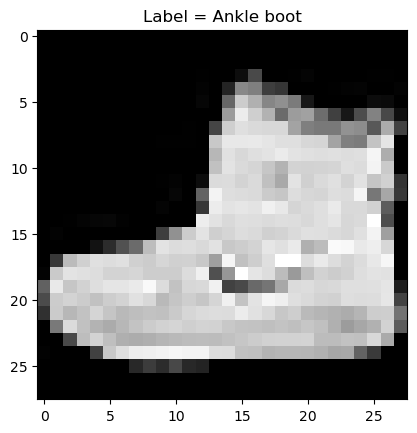

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline


# Showing a sample image from the normalized dataset.
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def print_image(img, label):
    img_norm = denorm(img)
    plt.imshow(img_norm[0], cmap='gray')
    plt.title(f'Label = {class_names[label]}')


img, label = train_dataset[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)
print_image(img, label)

In [ ]:
"""
Batching for the dataset, here we are using the batch size as 100.
But batch_size is a hypter parameter which can be tuned later on using grid search.
"""

from torch.utils.data import DataLoader

batch_size = 100

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)

first batch
torch.Size([100, 1, 28, 28])


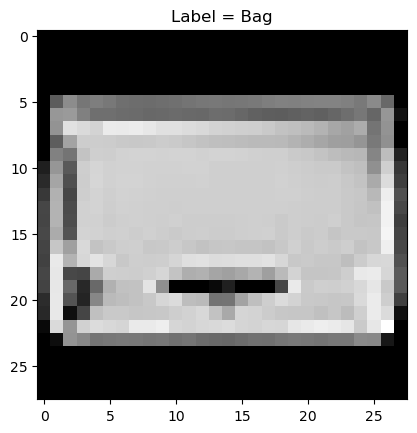

In [ ]:
# Loading a image from one of the batch.
for img_batch, label_batch in train_loader:
    print('first batch')
    print(img_batch.shape)
    print_image(img=img_batch[0], label=label_batch[0].item())
    break

# Step2. Train the GAN model to produce images in this new domain.

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image as PILImage


def show_images(images_path):
    """
    This method shows images from a given path, it will help us to visualize the output generated by the GAN.
    """

    n = len(images_path)
    plt.figure(figsize=(5*n, 5))

    for i, path in enumerate(images_path):
        # Plot first image
        plt.subplot(1, n, i+1)
        image = PILImage.open(path)
        plt.imshow(image)
        plt.title(path)
        plt.axis('off')

    plt.show()


In [ ]:
# Setting Device configuration to get performance boost

device = torch.device('cuda' if torch.cuda.is_available() else (
    'mps' if torch.backends.mps.is_available() else 'cpu'))

device

device(type='mps')

In [ ]:
# parameters specific to the dataset. Using it as golbal variable for the rest of the workbook.

image_size  = 784  # size of the image, as the size is 28*28, this will be input of the discriminator network.
hidden_size = 256  # this is a variable which will used to define the number of nodes in the hidden layers.
latent_size = 64   # it defines the input size of the generator network.

## Discriminator Network


In [ ]:
import torch.nn as nn

def discriminator_network():
    """ Base Discriminator Network, using the same network from the demo class."""
    return nn.Sequential(
        nn.Linear(image_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid())

D = discriminator_network()
D.to(device);

## Generator Network

In [ ]:
def generator_network():
    """ Base Generator Network, using the same network from the demo class."""
    return nn.Sequential(
        nn.Linear(latent_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, image_size),
        nn.Tanh())

G = generator_network()

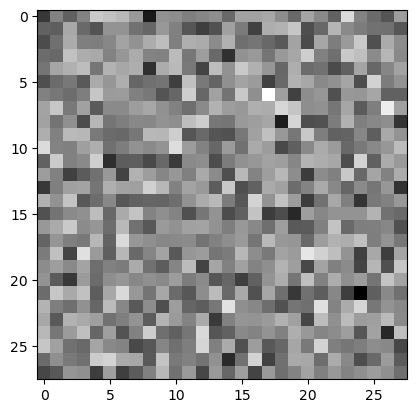

In [ ]:
# Sample image generated without any training.
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())
plt.imshow(gen_imgs[0], cmap='gray');

In [ ]:
# adding a resource for better performance.
G.to(device);

In [ ]:
# creating the sample directory where all the experiments will be done.
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

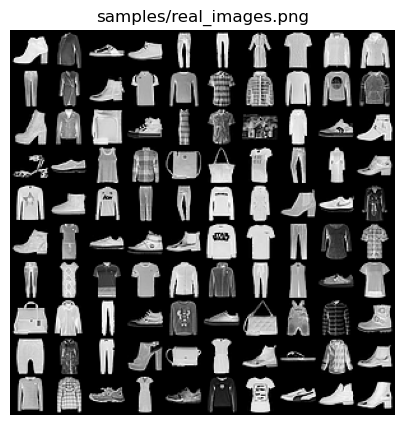

In [ ]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images, and display them.
for images, _ in train_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

show_images([os.path.join(sample_dir, 'real_images.png')])

In [ ]:
def save_fake_images(G, index, sample_dir, file_name=""):
    """
    This method will generate a image, by the G=generator and save it in the samples folder.
    """
    sample_vectors = torch.randn(batch_size, latent_size).to(device)

    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname  = 'fake_images-{0:0=4d}.png'.format(index) if file_name == "" else file_name

    print('\tSaving ',  os.path.join(sample_dir, fake_fname))
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)



In [ ]:
def train_discriminator(G, D, real_images, batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    """
    This method trains the dicriminator and adjust the netowrk parameter based on the error.
    """

    d_optimizer.zero_grad()

    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    real_score = D(real_images)
    d_loss_real = criterion(real_score, real_labels)

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    fake_score = D(fake_images)
    d_loss_fake = criterion(fake_score, fake_labels)

    d_loss = d_loss_real + d_loss_fake  # Combine losses
    d_loss.backward()                   # Compute gradients
    d_optimizer.step()                  # Adjust the parameters using backprop

    return d_loss, real_score, fake_score



def train_generator(G, D, batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    """
    This method traing the Generator Network, and it adjust its weight using backpropogation from loss.
    """

    g_optimizer.zero_grad()

    # Generate fake images and calculate loss
    real_labels = torch.ones(batch_size, 1).to(device)
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    fake_output = D(fake_images)
    g_loss = criterion(fake_output, real_labels) # Loss
    g_loss.backward()                            # Compute gradients
    g_optimizer.step()                           # Adjust the parameters using backprop
    return g_loss, fake_images


def train_gan(G, D, data_loader, num_epochs, sample_dir,
              batch_size, latent_size, criterion, g_optimizer, d_optimizer):

    """
    This is training method for the GAN, which individually train the Discriminator and Generator
    networks. It runs the algorithm for the num_epocs iterations on the batched training data.
    It also captures the different training metrics.
    It also saves the images generated during the training process.
    """

    if not os.path.exists(sample_dir):
        os.makedirs(sample_dir)

    save_fake_images(G, 0, sample_dir=sample_dir)

    total_step = len(data_loader)
    d_losses, g_losses, real_scores, fake_scores = [], [], [], []

    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(data_loader):

            # Load a batch & transform to vectors
            images = images.reshape(batch_size, -1).to(device)

            # Train the discriminator and generator
            d_loss, real_score, fake_score = train_discriminator(G, D, images, batch_size, latent_size,
                                                                 criterion, g_optimizer, d_optimizer)
            g_loss, fake_images            = train_generator(G, D, batch_size, latent_size,
                                                             criterion, g_optimizer, d_optimizer)

            # Inspect the losses
            if (i+1) % (total_step//3) == 0:
                d_losses.append(d_loss.item())
                g_losses.append(g_loss.item())
                real_scores.append(real_score.mean().item())
                fake_scores.append(fake_score.mean().item())
                print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], ' +
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, ' +
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')


        # Sample and save images
        save_fake_images(G, epoch+1, sample_dir)

    return d_losses, g_losses, real_scores, fake_scores



In [ ]:
"""
This is the training for the
"""
D = discriminator_network()
D.to(device);

G = generator_network()
G.to(device);

num_epochs  = 150
criterion   = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

d_losses, g_losses, real_scores, fake_scores = train_gan(G, D, train_loader, num_epochs, sample_dir,
                                                         batch_size, latent_size,
                                                         criterion, g_optimizer, d_optimizer)

	Saving  samples_new/fake_images-0000.png
Epoch [0/150], Step [200/600], d_loss: 0.0555, g_loss: 4.0152, D(x): 0.99, D(G(z)): 0.04
Epoch [0/150], Step [400/600], d_loss: 0.0430, g_loss: 5.4396, D(x): 0.99, D(G(z)): 0.03
Epoch [0/150], Step [600/600], d_loss: 0.0372, g_loss: 4.8252, D(x): 0.99, D(G(z)): 0.02
	Saving  samples_new/fake_images-0001.png
Epoch [1/150], Step [200/600], d_loss: 0.0513, g_loss: 4.1642, D(x): 1.00, D(G(z)): 0.05
Epoch [1/150], Step [400/600], d_loss: 0.0883, g_loss: 3.7751, D(x): 0.97, D(G(z)): 0.05
Epoch [1/150], Step [600/600], d_loss: 0.0556, g_loss: 5.4171, D(x): 0.97, D(G(z)): 0.01
	Saving  samples_new/fake_images-0002.png
Epoch [2/150], Step [200/600], d_loss: 0.0374, g_loss: 6.4519, D(x): 0.98, D(G(z)): 0.01
Epoch [2/150], Step [400/600], d_loss: 0.0217, g_loss: 6.6675, D(x): 1.00, D(G(z)): 0.02
Epoch [2/150], Step [600/600], d_loss: 0.0751, g_loss: 7.3378, D(x): 0.98, D(G(z)): 0.04
	Saving  samples_new/fake_images-0003.png
Epoch [3/150], Step [200/600], 

Epoch [26/150], Step [400/600], d_loss: 0.5912, g_loss: 2.9896, D(x): 0.87, D(G(z)): 0.20
Epoch [26/150], Step [600/600], d_loss: 0.4292, g_loss: 3.5517, D(x): 0.89, D(G(z)): 0.16
	Saving  samples_new/fake_images-0027.png
Epoch [27/150], Step [200/600], d_loss: 0.5897, g_loss: 2.5648, D(x): 0.78, D(G(z)): 0.10
Epoch [27/150], Step [400/600], d_loss: 0.5711, g_loss: 2.7973, D(x): 0.84, D(G(z)): 0.20
Epoch [27/150], Step [600/600], d_loss: 0.4562, g_loss: 3.1705, D(x): 0.91, D(G(z)): 0.20
	Saving  samples_new/fake_images-0028.png
Epoch [28/150], Step [200/600], d_loss: 0.6159, g_loss: 2.6264, D(x): 0.81, D(G(z)): 0.19
Epoch [28/150], Step [400/600], d_loss: 0.6757, g_loss: 2.8553, D(x): 0.76, D(G(z)): 0.14
Epoch [28/150], Step [600/600], d_loss: 0.7891, g_loss: 2.4553, D(x): 0.75, D(G(z)): 0.18
	Saving  samples_new/fake_images-0029.png
Epoch [29/150], Step [200/600], d_loss: 0.4816, g_loss: 3.0280, D(x): 0.84, D(G(z)): 0.12
Epoch [29/150], Step [400/600], d_loss: 0.7061, g_loss: 2.6589, 

Epoch [52/150], Step [600/600], d_loss: 0.4575, g_loss: 2.5132, D(x): 0.83, D(G(z)): 0.15
	Saving  samples_new/fake_images-0053.png
Epoch [53/150], Step [200/600], d_loss: 0.6186, g_loss: 2.1927, D(x): 0.80, D(G(z)): 0.18
Epoch [53/150], Step [400/600], d_loss: 0.5159, g_loss: 2.9051, D(x): 0.80, D(G(z)): 0.10
Epoch [53/150], Step [600/600], d_loss: 0.5100, g_loss: 2.2762, D(x): 0.84, D(G(z)): 0.19
	Saving  samples_new/fake_images-0054.png
Epoch [54/150], Step [200/600], d_loss: 0.7815, g_loss: 2.3438, D(x): 0.74, D(G(z)): 0.18
Epoch [54/150], Step [400/600], d_loss: 0.5903, g_loss: 2.7996, D(x): 0.79, D(G(z)): 0.18
Epoch [54/150], Step [600/600], d_loss: 0.7504, g_loss: 2.2111, D(x): 0.76, D(G(z)): 0.24
	Saving  samples_new/fake_images-0055.png
Epoch [55/150], Step [200/600], d_loss: 0.6109, g_loss: 2.6752, D(x): 0.78, D(G(z)): 0.15
Epoch [55/150], Step [400/600], d_loss: 0.8406, g_loss: 1.8050, D(x): 0.76, D(G(z)): 0.26
Epoch [55/150], Step [600/600], d_loss: 0.7769, g_loss: 2.8096, 

Epoch [79/150], Step [200/600], d_loss: 0.5240, g_loss: 2.6533, D(x): 0.80, D(G(z)): 0.15
Epoch [79/150], Step [400/600], d_loss: 0.9237, g_loss: 2.3018, D(x): 0.71, D(G(z)): 0.26
Epoch [79/150], Step [600/600], d_loss: 0.8756, g_loss: 2.0145, D(x): 0.75, D(G(z)): 0.31
	Saving  samples_new/fake_images-0080.png
Epoch [80/150], Step [200/600], d_loss: 0.8606, g_loss: 2.1833, D(x): 0.74, D(G(z)): 0.29
Epoch [80/150], Step [400/600], d_loss: 0.8380, g_loss: 1.9901, D(x): 0.83, D(G(z)): 0.34
Epoch [80/150], Step [600/600], d_loss: 0.8265, g_loss: 2.1830, D(x): 0.77, D(G(z)): 0.24
	Saving  samples_new/fake_images-0081.png
Epoch [81/150], Step [200/600], d_loss: 0.6658, g_loss: 2.7759, D(x): 0.74, D(G(z)): 0.16
Epoch [81/150], Step [400/600], d_loss: 0.9014, g_loss: 2.0720, D(x): 0.72, D(G(z)): 0.28
Epoch [81/150], Step [600/600], d_loss: 0.8035, g_loss: 1.6064, D(x): 0.77, D(G(z)): 0.28
	Saving  samples_new/fake_images-0082.png
Epoch [82/150], Step [200/600], d_loss: 0.8479, g_loss: 1.6566, 

Epoch [105/150], Step [400/600], d_loss: 1.2122, g_loss: 1.8648, D(x): 0.66, D(G(z)): 0.36
Epoch [105/150], Step [600/600], d_loss: 0.9294, g_loss: 1.6187, D(x): 0.74, D(G(z)): 0.33
	Saving  samples_new/fake_images-0106.png
Epoch [106/150], Step [200/600], d_loss: 0.7836, g_loss: 1.6645, D(x): 0.72, D(G(z)): 0.27
Epoch [106/150], Step [400/600], d_loss: 0.8087, g_loss: 2.0112, D(x): 0.70, D(G(z)): 0.20
Epoch [106/150], Step [600/600], d_loss: 0.7775, g_loss: 1.7510, D(x): 0.75, D(G(z)): 0.25
	Saving  samples_new/fake_images-0107.png
Epoch [107/150], Step [200/600], d_loss: 0.8532, g_loss: 1.5242, D(x): 0.77, D(G(z)): 0.32
Epoch [107/150], Step [400/600], d_loss: 0.9990, g_loss: 1.5842, D(x): 0.68, D(G(z)): 0.32
Epoch [107/150], Step [600/600], d_loss: 0.7050, g_loss: 2.4228, D(x): 0.75, D(G(z)): 0.22
	Saving  samples_new/fake_images-0108.png
Epoch [108/150], Step [200/600], d_loss: 0.7158, g_loss: 1.7676, D(x): 0.74, D(G(z)): 0.25
Epoch [108/150], Step [400/600], d_loss: 1.0897, g_loss

Epoch [131/150], Step [600/600], d_loss: 1.0287, g_loss: 1.3102, D(x): 0.82, D(G(z)): 0.43
	Saving  samples_new/fake_images-0132.png
Epoch [132/150], Step [200/600], d_loss: 0.8624, g_loss: 2.0018, D(x): 0.69, D(G(z)): 0.27
Epoch [132/150], Step [400/600], d_loss: 1.0345, g_loss: 1.5743, D(x): 0.68, D(G(z)): 0.33
Epoch [132/150], Step [600/600], d_loss: 0.9374, g_loss: 1.7810, D(x): 0.74, D(G(z)): 0.34
	Saving  samples_new/fake_images-0133.png
Epoch [133/150], Step [200/600], d_loss: 1.1665, g_loss: 1.8010, D(x): 0.60, D(G(z)): 0.30
Epoch [133/150], Step [400/600], d_loss: 0.9503, g_loss: 1.2679, D(x): 0.70, D(G(z)): 0.33
Epoch [133/150], Step [600/600], d_loss: 0.9480, g_loss: 1.6867, D(x): 0.66, D(G(z)): 0.28
	Saving  samples_new/fake_images-0134.png
Epoch [134/150], Step [200/600], d_loss: 1.0271, g_loss: 1.5731, D(x): 0.65, D(G(z)): 0.34
Epoch [134/150], Step [400/600], d_loss: 0.9284, g_loss: 1.4747, D(x): 0.67, D(G(z)): 0.31
Epoch [134/150], Step [600/600], d_loss: 1.2430, g_loss

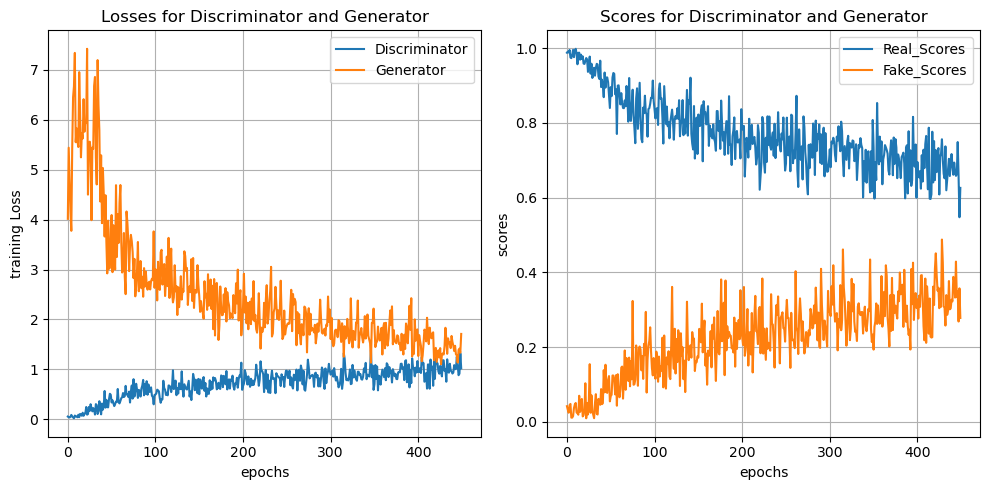

In [ ]:
def plot_side_by_side(d_losses, g_losses, real_scores, fake_scores):
    """
    This metod plots the different training metrics side by side.
    """

    plt.figure(figsize=(10,5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(d_losses, '-')
    plt.plot(g_losses, '-')
    plt.xlabel("epochs")
    plt.ylabel("training Loss")
    plt.legend(['Discriminator', 'Generator'])
    plt.grid(True)
    plt.title("Losses for Discriminator and Generator")

    # Plot scores
    plt.subplot(1, 2, 2)
    plt.plot(real_scores, '-')
    plt.plot(fake_scores, '-')
    plt.xlabel("epochs")
    plt.ylabel("scores")
    plt.legend(['Real_Scores', 'Fake_Scores'])
    plt.grid(True)
    plt.title("Scores for Discriminator and Generator")

    plt.tight_layout()
    plt.show()

plot_side_by_side(d_losses, g_losses, real_scores, fake_scores)

<span ><h2 style="color:blue">Chart Explanination</h2></span>

* As we can see that around 400 the epoch loss chart shows the equilibrium.
* The scores plot did not shows as good of equilibrium but it have positive trend, if we increase the training epochs, we may see similar results.
* The loss in Generator was very high initially, but gradually it decreased, show the improvement in the generation.

# Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.


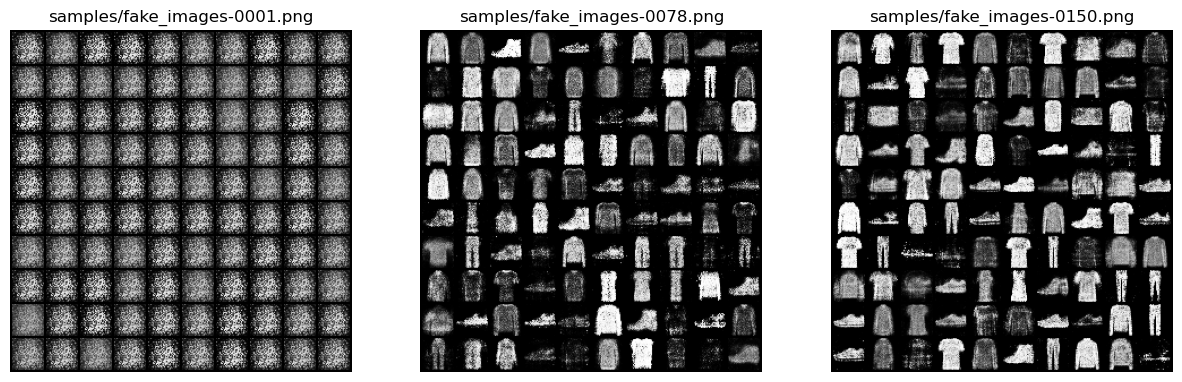

In [ ]:
def select_training_samples(directory, prefix="fake_images-", suffix=".png"):
    """
    This method shows some of the sample images generated during the training process.
    It shows 3 images, 1 from the begining of the training, one from the end of the training process
    and one from the middle, to show the model's progression and hows its learning.
    """
    files = os.listdir(directory)

    candidates = []
    for file in files:
        if (os.path.isfile(os.path.join(directory, file)) and not file.startswith("fake_images-0000") and
             file.startswith(prefix) and file.endswith(suffix)):
            candidates.append(file)

    candidates.sort(key=lambda x: os.path.getmtime(os.path.join(directory, x)))
    oldest_file = candidates[0]
    latest_file = candidates[-1]
    middle_file = candidates[len(files)//2]

    return list(map(lambda file: f'{sample_dir}/{file}', [oldest_file, middle_file, latest_file]))

show_images(select_training_samples(sample_dir))

### Showing 3 images from 3 differnet states of model, from left to right as the training increases, GAN is getting more capable to show real life pictures.

<span ><h1 style="color:blue">Challenges/ Difficulties Faced in training</h1></span>

* First of all most difficult part was training the GAN, it takes so much time to just train it even 10 or 20 iterations. This makes the whole process slow and if I want to play with different parameters its kind of become difficult.
* Loss values from the training data is not as smooth like gradient descent and had to run more iterations to see the clear trend, which again took a lot of time.
* Batched images quality improved overtime, but its not visible at instant and thats the proof that traing is going fine, as there is no concept of accuracy.
* As the images are normalized plotting them was not very intutive, and had difficulty to relate with the model.

# Step4. Save the model weights in the folder to be used later.


In [ ]:
# Created the checkpoint for the discriminator model.
d_checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': D.state_dict(),
    'optimizer_state_dict': d_optimizer.state_dict(),
}

torch.save(d_checkpoint, f'{sample_dir}/discriminator_checkpoint.ckpt')

In [ ]:
# Created the checkpoint for the generator model.
g_checkpoint = {
    'epoch': num_epochs,
    'model_state_dict': G.state_dict(),
    'optimizer_state_dict': g_optimizer.state_dict(),
}
1
torch.save(g_checkpoint, f'{sample_dir}/generator_checkpoint.ckpt')

# Step5. Load the model using the saved weights.


In [ ]:
""" Reloading the Discriminator model from the saved checkpoint. """

Dl= discriminator_network()

# Load the checkpoint
d_checkpoint = torch.load(f'{sample_dir}/discriminator_checkpoint.ckpt')

# Load model weights and optimizer state
Dl.load_state_dict(d_checkpoint['model_state_dict'])
d_optimizer.load_state_dict(d_checkpoint['optimizer_state_dict'])
num_epoch = d_checkpoint['epoch']

print(f"Discriminator Model's training for {num_epoch} iternations,  state_dict:")
for param_tensor in Dl.state_dict():
    print("\t", param_tensor, "\t", Dl.state_dict()[param_tensor].size())

Discriminator Model's training for 150 iternations,  state_dict:
	 0.weight 	 torch.Size([256, 784])
	 0.bias 	 torch.Size([256])
	 2.weight 	 torch.Size([256, 256])
	 2.bias 	 torch.Size([256])
	 4.weight 	 torch.Size([1, 256])
	 4.bias 	 torch.Size([1])


In [ ]:
""" Reloading the Generator model from the saved checkpoint. """

Gl= generator_network()

# Load the checkpoint
g_checkpoint = torch.load(f'{sample_dir}/generator_checkpoint.ckpt')

# Load model weights and optimizer state
Gl.load_state_dict(g_checkpoint['model_state_dict'])
g_optimizer.load_state_dict(g_checkpoint['optimizer_state_dict'])
num_epoch = g_checkpoint['epoch']

print(f"Generator Model's training for {num_epoch} iternations,  state_dict:")
for param_tensor in Gl.state_dict():
    print("\t", param_tensor, "\t", Gl.state_dict()[param_tensor].size())

Generator Model's training for 150 iternations,  state_dict:
	 0.weight 	 torch.Size([256, 64])
	 0.bias 	 torch.Size([256])
	 2.weight 	 torch.Size([256, 256])
	 2.bias 	 torch.Size([256])
	 4.weight 	 torch.Size([784, 256])
	 4.bias 	 torch.Size([784])


# Step 6: Re-train the GAN model to see if you can improve.


### To improve the performance of the GAN making a complex network by adding a new layer and making one of the layer wider. Other than that, adding betas in the optimizer.

In [ ]:
def discriminator_network_new():
    """ New Discriminator Network with added layer and 1 wide layer."""
    return nn.Sequential(
        nn.Linear(image_size, hidden_size*2),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size*2, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        nn.Sigmoid())

In [ ]:
def generator_network_new():
    """ New Generator Network with added layer and 1 wide layer."""
    return nn.Sequential(
        nn.Linear(latent_size, hidden_size*2),
        nn.ReLU(),
        nn.Linear(hidden_size*2, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, image_size),
        nn.Tanh())

In [ ]:
"""
Training of the new improved GAN which uses the new network and same optimier, but with different parameters.
"""

D_new = discriminator_network_new()
D_new.to(device);

G_new = generator_network_new()
G_new.to(device);


num_epochs  = 150
criterion_new   = nn.BCELoss()
d_optimizer_new = torch.optim.Adam(D_new.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer_new = torch.optim.Adam(G_new.parameters(), lr=0.0002, betas=(0.5, 0.999))

sample_dir = "samples_new"

d_losses_new, g_losses_new, real_scores_new, fake_scores_new = train_gan(G_new, D_new,
                                                                         train_loader, num_epochs, sample_dir,
                                                                         batch_size, latent_size,
                                                                         criterion_new,
                                                                         g_optimizer_new, d_optimizer_new)


	Saving  samples_new/fake_images-0000.png
Epoch [0/150], Step [200/600], d_loss: 2.1605, g_loss: 1.0928, D(x): 1.00, D(G(z)): 0.88
Epoch [0/150], Step [400/600], d_loss: 0.2805, g_loss: 4.4591, D(x): 0.92, D(G(z)): 0.02
Epoch [0/150], Step [600/600], d_loss: 0.2041, g_loss: 4.7826, D(x): 0.90, D(G(z)): 0.03
	Saving  samples_new/fake_images-0001.png
Epoch [1/150], Step [200/600], d_loss: 0.2424, g_loss: 4.3633, D(x): 0.89, D(G(z)): 0.02
Epoch [1/150], Step [400/600], d_loss: 0.7902, g_loss: 8.2527, D(x): 0.96, D(G(z)): 0.52
Epoch [1/150], Step [600/600], d_loss: 1.5046, g_loss: 9.5591, D(x): 0.81, D(G(z)): 0.00
	Saving  samples_new/fake_images-0002.png
Epoch [2/150], Step [200/600], d_loss: 0.1519, g_loss: 4.5685, D(x): 0.95, D(G(z)): 0.04
Epoch [2/150], Step [400/600], d_loss: 0.9078, g_loss: 7.2706, D(x): 0.79, D(G(z)): 0.00
Epoch [2/150], Step [600/600], d_loss: 0.1144, g_loss: 4.1084, D(x): 0.97, D(G(z)): 0.06
	Saving  samples_new/fake_images-0003.png
Epoch [3/150], Step [200/600], 

Epoch [26/150], Step [400/600], d_loss: 1.1135, g_loss: 1.3564, D(x): 0.62, D(G(z)): 0.34
Epoch [26/150], Step [600/600], d_loss: 1.0932, g_loss: 1.3916, D(x): 0.54, D(G(z)): 0.25
	Saving  samples_new/fake_images-0027.png
Epoch [27/150], Step [200/600], d_loss: 1.1529, g_loss: 1.3645, D(x): 0.66, D(G(z)): 0.42
Epoch [27/150], Step [400/600], d_loss: 1.0750, g_loss: 1.0582, D(x): 0.63, D(G(z)): 0.33
Epoch [27/150], Step [600/600], d_loss: 1.0405, g_loss: 1.3469, D(x): 0.74, D(G(z)): 0.45
	Saving  samples_new/fake_images-0028.png
Epoch [28/150], Step [200/600], d_loss: 1.1212, g_loss: 1.0613, D(x): 0.55, D(G(z)): 0.31
Epoch [28/150], Step [400/600], d_loss: 0.9658, g_loss: 1.3109, D(x): 0.66, D(G(z)): 0.36
Epoch [28/150], Step [600/600], d_loss: 0.9922, g_loss: 1.2935, D(x): 0.63, D(G(z)): 0.34
	Saving  samples_new/fake_images-0029.png
Epoch [29/150], Step [200/600], d_loss: 1.2168, g_loss: 1.2987, D(x): 0.64, D(G(z)): 0.41
Epoch [29/150], Step [400/600], d_loss: 0.9595, g_loss: 1.4332, 

Epoch [52/150], Step [600/600], d_loss: 1.0952, g_loss: 1.0146, D(x): 0.63, D(G(z)): 0.39
	Saving  samples_new/fake_images-0053.png
Epoch [53/150], Step [200/600], d_loss: 1.1671, g_loss: 1.0938, D(x): 0.57, D(G(z)): 0.36
Epoch [53/150], Step [400/600], d_loss: 1.1590, g_loss: 1.1086, D(x): 0.57, D(G(z)): 0.34
Epoch [53/150], Step [600/600], d_loss: 1.1934, g_loss: 1.1003, D(x): 0.60, D(G(z)): 0.41
	Saving  samples_new/fake_images-0054.png
Epoch [54/150], Step [200/600], d_loss: 1.0640, g_loss: 1.0369, D(x): 0.63, D(G(z)): 0.36
Epoch [54/150], Step [400/600], d_loss: 1.1233, g_loss: 1.2867, D(x): 0.64, D(G(z)): 0.38
Epoch [54/150], Step [600/600], d_loss: 1.1241, g_loss: 1.3130, D(x): 0.66, D(G(z)): 0.42
	Saving  samples_new/fake_images-0055.png
Epoch [55/150], Step [200/600], d_loss: 1.0696, g_loss: 1.0714, D(x): 0.63, D(G(z)): 0.36
Epoch [55/150], Step [400/600], d_loss: 1.1192, g_loss: 1.0330, D(x): 0.57, D(G(z)): 0.34
Epoch [55/150], Step [600/600], d_loss: 0.9927, g_loss: 1.3121, 

Epoch [79/150], Step [200/600], d_loss: 1.0400, g_loss: 1.1526, D(x): 0.57, D(G(z)): 0.28
Epoch [79/150], Step [400/600], d_loss: 1.1837, g_loss: 1.3201, D(x): 0.60, D(G(z)): 0.38
Epoch [79/150], Step [600/600], d_loss: 0.9669, g_loss: 1.0638, D(x): 0.70, D(G(z)): 0.39
	Saving  samples_new/fake_images-0080.png
Epoch [80/150], Step [200/600], d_loss: 0.9690, g_loss: 1.1272, D(x): 0.67, D(G(z)): 0.37
Epoch [80/150], Step [400/600], d_loss: 1.0472, g_loss: 1.1976, D(x): 0.65, D(G(z)): 0.38
Epoch [80/150], Step [600/600], d_loss: 1.1049, g_loss: 1.1146, D(x): 0.62, D(G(z)): 0.38
	Saving  samples_new/fake_images-0081.png
Epoch [81/150], Step [200/600], d_loss: 1.1608, g_loss: 1.1855, D(x): 0.63, D(G(z)): 0.40
Epoch [81/150], Step [400/600], d_loss: 1.1472, g_loss: 1.1576, D(x): 0.62, D(G(z)): 0.35
Epoch [81/150], Step [600/600], d_loss: 1.1226, g_loss: 1.1746, D(x): 0.60, D(G(z)): 0.36
	Saving  samples_new/fake_images-0082.png
Epoch [82/150], Step [200/600], d_loss: 1.1091, g_loss: 1.1694, 

Epoch [105/150], Step [400/600], d_loss: 1.0479, g_loss: 1.3165, D(x): 0.64, D(G(z)): 0.35
Epoch [105/150], Step [600/600], d_loss: 1.0339, g_loss: 1.2553, D(x): 0.61, D(G(z)): 0.31
	Saving  samples_new/fake_images-0106.png
Epoch [106/150], Step [200/600], d_loss: 0.9567, g_loss: 1.2167, D(x): 0.69, D(G(z)): 0.36
Epoch [106/150], Step [400/600], d_loss: 1.0058, g_loss: 1.3041, D(x): 0.67, D(G(z)): 0.36
Epoch [106/150], Step [600/600], d_loss: 1.0642, g_loss: 1.4673, D(x): 0.62, D(G(z)): 0.34
	Saving  samples_new/fake_images-0107.png
Epoch [107/150], Step [200/600], d_loss: 1.0995, g_loss: 1.2760, D(x): 0.64, D(G(z)): 0.35
Epoch [107/150], Step [400/600], d_loss: 1.0886, g_loss: 1.1475, D(x): 0.55, D(G(z)): 0.30
Epoch [107/150], Step [600/600], d_loss: 1.0170, g_loss: 1.4100, D(x): 0.65, D(G(z)): 0.35
	Saving  samples_new/fake_images-0108.png
Epoch [108/150], Step [200/600], d_loss: 0.8982, g_loss: 1.3738, D(x): 0.71, D(G(z)): 0.35
Epoch [108/150], Step [400/600], d_loss: 1.0695, g_loss

Epoch [131/150], Step [600/600], d_loss: 0.8466, g_loss: 1.4056, D(x): 0.72, D(G(z)): 0.30
	Saving  samples_new/fake_images-0132.png
Epoch [132/150], Step [200/600], d_loss: 0.8657, g_loss: 1.3764, D(x): 0.69, D(G(z)): 0.28
Epoch [132/150], Step [400/600], d_loss: 0.8239, g_loss: 1.3275, D(x): 0.77, D(G(z)): 0.34
Epoch [132/150], Step [600/600], d_loss: 1.0396, g_loss: 1.3159, D(x): 0.70, D(G(z)): 0.38
	Saving  samples_new/fake_images-0133.png
Epoch [133/150], Step [200/600], d_loss: 0.9259, g_loss: 1.4395, D(x): 0.71, D(G(z)): 0.36
Epoch [133/150], Step [400/600], d_loss: 0.9037, g_loss: 1.1858, D(x): 0.70, D(G(z)): 0.32
Epoch [133/150], Step [600/600], d_loss: 0.9430, g_loss: 1.4321, D(x): 0.68, D(G(z)): 0.33
	Saving  samples_new/fake_images-0134.png
Epoch [134/150], Step [200/600], d_loss: 0.9946, g_loss: 1.3744, D(x): 0.65, D(G(z)): 0.31
Epoch [134/150], Step [400/600], d_loss: 0.9520, g_loss: 1.3149, D(x): 0.64, D(G(z)): 0.28
Epoch [134/150], Step [600/600], d_loss: 0.9551, g_loss

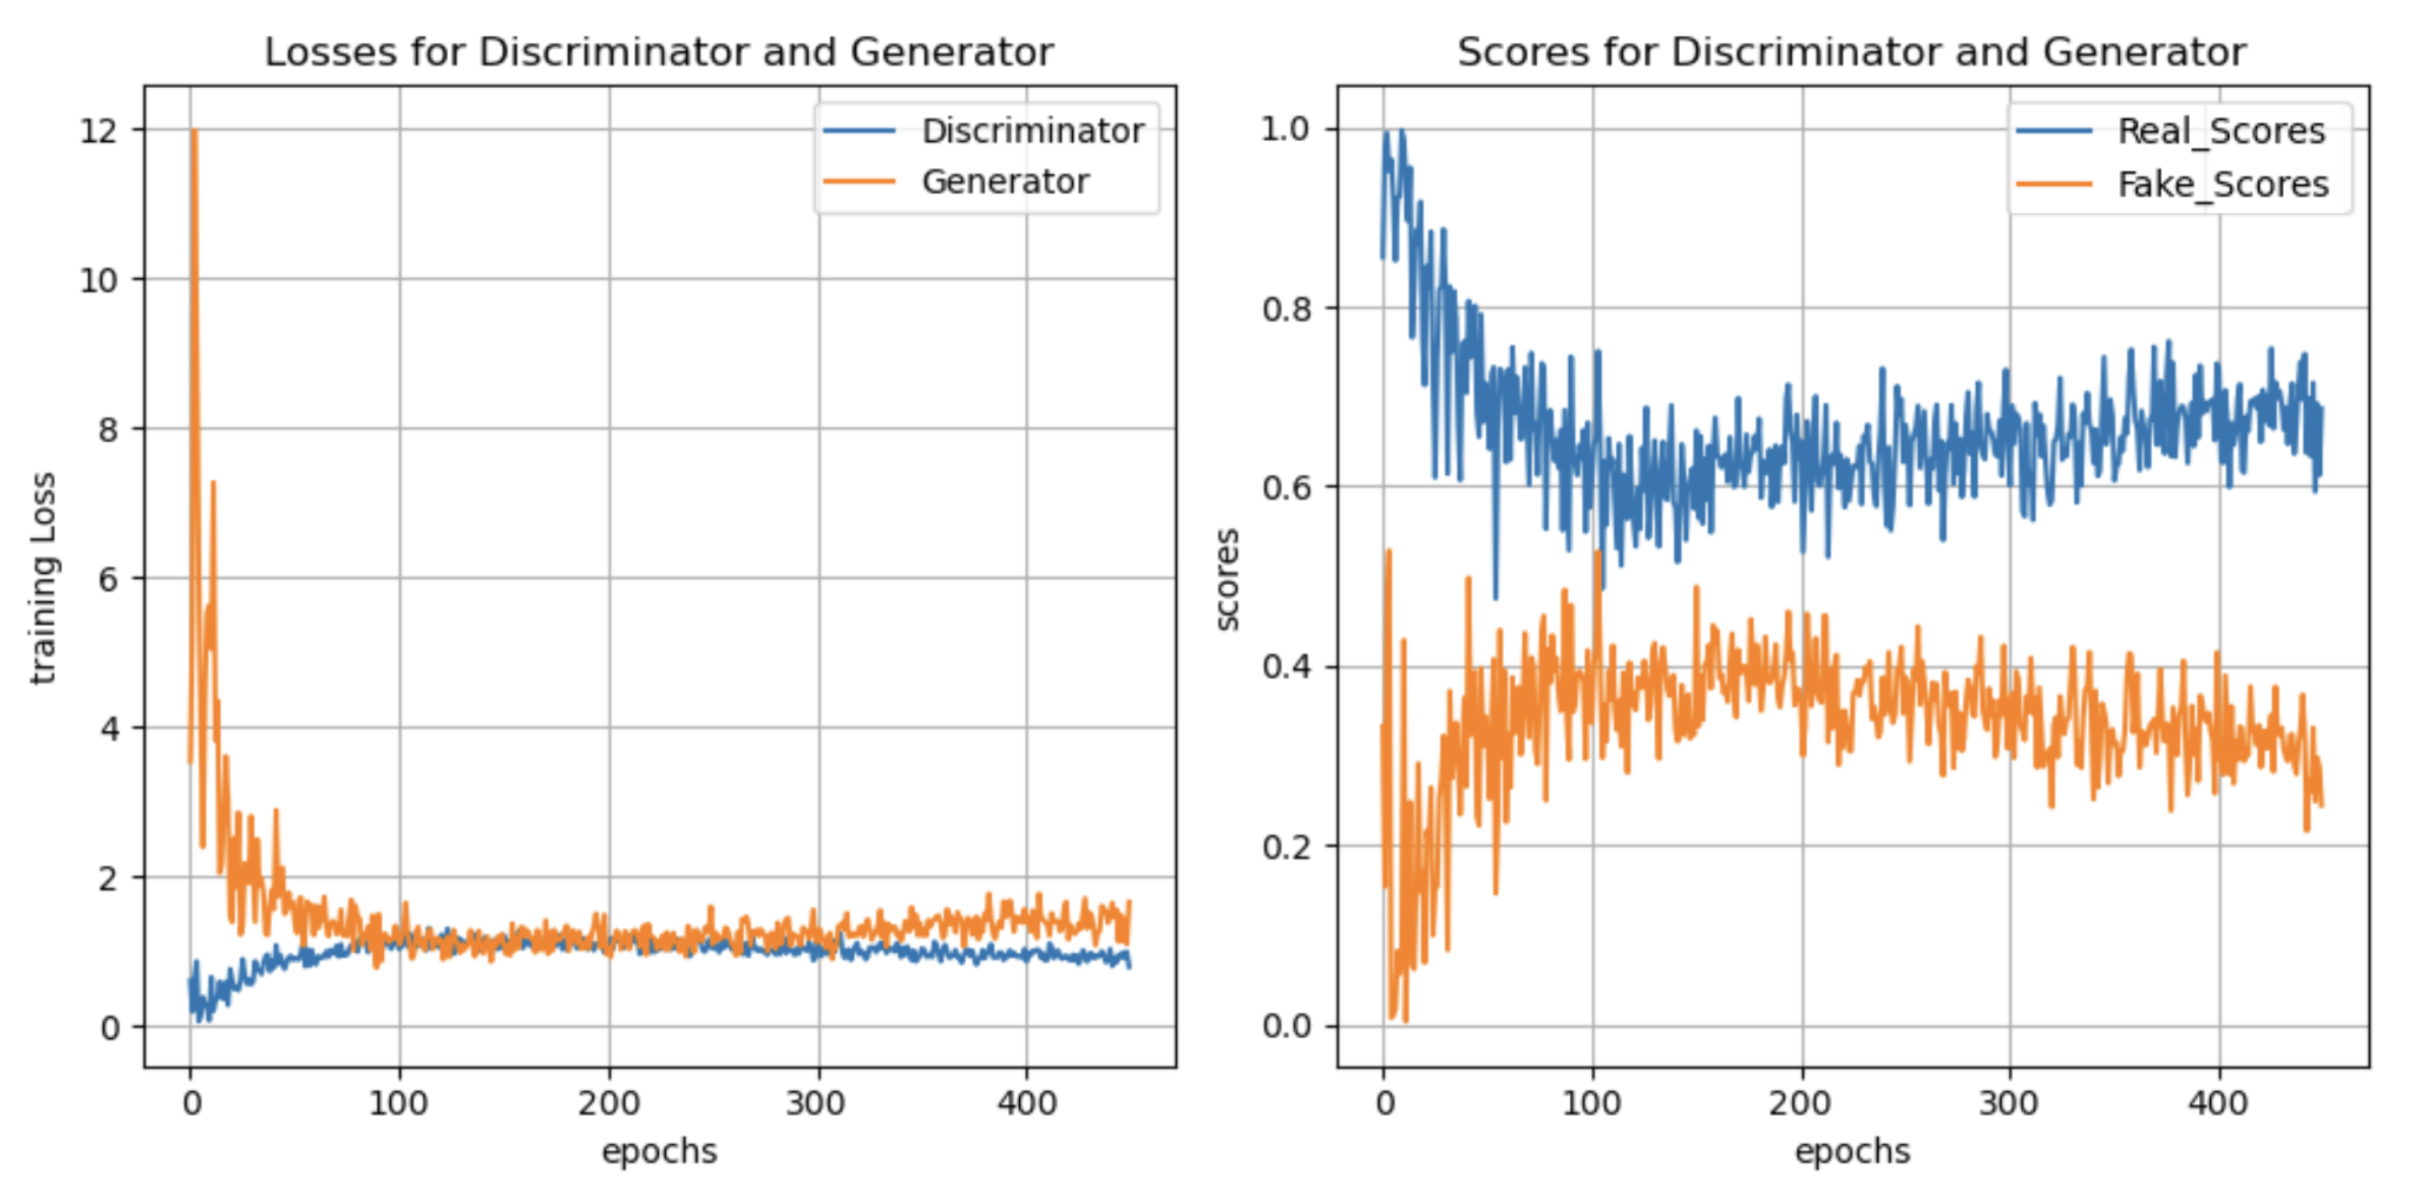

In [121]:
# Plots the training metrics for Improved GAN which used new model structure, only loss function is different.
plot_side_by_side(d_losses_new, g_losses_new, real_scores_new, fake_scores_new)

<span ><h2 style="color:blue">Chart Explanination And Comparision against the Base Model</h2></span>

* As we can see that with the improved model achieves the equilibrium faster than the base model. Which means, the discriminator network is not successfully able to differentiate between the real and generated images. Hinting towards good system performance.

* The scores plot also signifies the same.
* Later we can see taht after 200 epochs, the model started showing signs of overfitting.

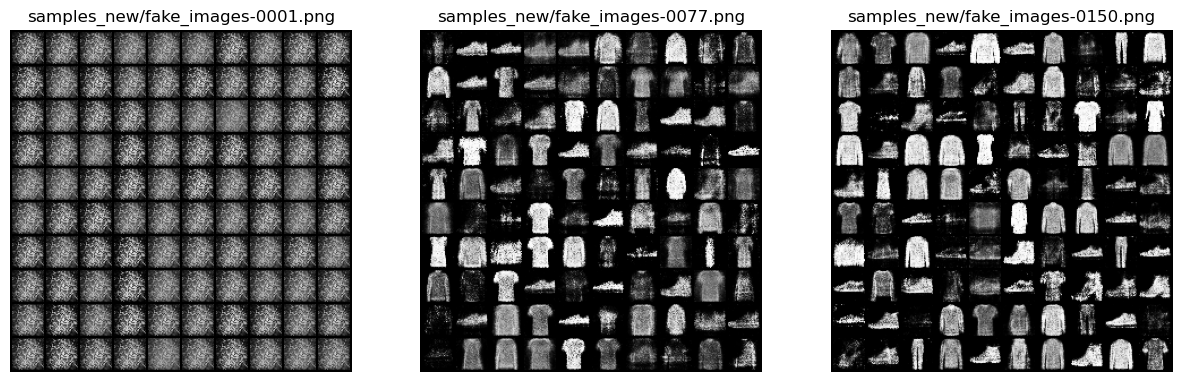

In [ ]:
# Showing some of the sample images generated by the model.
show_images(select_training_samples(sample_dir))

### Showing 3 images from 3 differnet states of model, from left to right as the training increases, GAN is getting more capable to show real life pictures.

# Step 7: Save the model weights without using checkpoints.


In [ ]:
# Saving the model weights without checkpoints.
torch.save(D_new.state_dict(), f'{sample_dir}/discriminator_model_weights.pth')
torch.save(G_new.state_dict(), f'{sample_dir}/generator_model_weights.pth')

# Step 8: Load the model weights without using checkpoints

In [ ]:
# Loading the trained saved Discriminator Network.
D_new = discriminator_network_new()
D_new.load_state_dict(torch.load(f'{sample_dir}/discriminator_model_weights.pth'))
print("\nDiscriminator Model's state_dict:")
for param_tensor in Dnew.state_dict():
    print("\t", param_tensor, "\t", D_new.state_dict()[param_tensor].size())



Discriminator Model's state_dict:
	 0.weight 	 torch.Size([512, 784])
	 0.bias 	 torch.Size([512])
	 2.weight 	 torch.Size([256, 512])
	 2.bias 	 torch.Size([256])
	 4.weight 	 torch.Size([256, 256])
	 4.bias 	 torch.Size([256])
	 6.weight 	 torch.Size([1, 256])
	 6.bias 	 torch.Size([1])


In [ ]:
# Loading the trained saved Generator Network.
G_new = generator_network_new()
G_new.load_state_dict(torch.load(f'{sample_dir}/generator_model_weights.pth'))
print("\nGenerator Model's state_dict:")
for param_tensor in Gnew.state_dict():
    print("\t", param_tensor, "\t", G_new.state_dict()[param_tensor].size())


Generator Model's state_dict:
	 0.weight 	 torch.Size([512, 64])
	 0.bias 	 torch.Size([512])
	 2.weight 	 torch.Size([256, 512])
	 2.bias 	 torch.Size([256])
	 4.weight 	 torch.Size([256, 256])
	 4.bias 	 torch.Size([256])
	 6.weight 	 torch.Size([784, 256])
	 6.bias 	 torch.Size([784])



<span ><h1 style="color:red">Part-2 LSGAN</h1 ></span>


Formula for the Loss funcion in LSGAN, as it uses the Mean Square Error

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*IAr9NKm1nrVQLVgOdD5J4g.png" width="620" >


# Repeat the steps 1-6 with Least Square GAN and compare it with GAN results

In [ ]:
"""
Rewriting the training algorithm as the loss function has been changes and now we have to
divide by 2 to get the right loss function.
"""

def train_lsgan_discriminator(G, D, real_images, batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    """
    This method trains the dicriminator and adjust the netowrk parameter based on the error.
    """

    d_optimizer.zero_grad()

    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
    z = torch.randn(batch_size, latent_size).to(device)

    # Loss for real images
    real_score = D(real_images)
    d_loss_real = criterion(real_score, real_labels)

    # Loss for fake images
    fake_images = G(z)
    fake_score = D(fake_images)
    d_loss_fake = criterion(fake_score, fake_labels)

    d_loss = 1/2 * (d_loss_real + d_loss_fake)  # Combine losses
    d_loss.backward()                           # Compute gradients
    d_optimizer.step()                          # Adjust the parameters using backprop

    return d_loss, real_score, fake_score


def train_lsgan_generator2(G, D, batch_size, latent_size, criterion, g_optimizer, d_optimizer):
    """
    This method traing the Generator Network, and it adjust its weight using backpropogation from loss.
    """

    g_optimizer.zero_grad()

    # Generate fake images and calculate loss
    real_labels = torch.ones(batch_size, 1).to(device)
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    fake_output = D(fake_images)
    g_loss = 1/2 * criterion(fake_output, real_labels) # Loss
    g_loss.backward()                                  # Compute gradients
    g_optimizer.step()                                 # Adjust the parameters using backprop

    return g_loss, fake_images



def train_lsgan_gan(G, D, data_loader, num_epochs, sample_dir,
              batch_size, latent_size, criterion, g_optimizer, d_optimizer):

    """
    This is training method for the GAN, which individually train the Discriminator and Generator
    networks. It runs the algorithm for the num_epocs iterations on the batched training data.
    It also captures the different training metrics.
    It also saves the images generated during the training process.
    """

    if not os.path.exists(sample_dir):
        os.makedirs(sample_dir)

    save_fake_images(G, 0, sample_dir=sample_dir)

    total_step = len(data_loader)
    d_losses, g_losses, real_scores, fake_scores = [], [], [], []

    for epoch in range(num_epochs):
        for i, (images, _) in enumerate(data_loader):

            # Load a batch & transform to vectors
            images = images.reshape(batch_size, -1).to(device)

            # Train the discriminator and generator
            d_loss, real_score, fake_score = train_lsgan_discriminator(G, D, images, batch_size, latent_size,
                                                                       criterion, g_optimizer, d_optimizer)
            g_loss, fake_images = train_lsgan_generator2(G, D, batch_size, latent_size,
                                                         criterion, g_optimizer, d_optimizer)

            # Inspect the losses
            if (i+1) % (total_step//3) == 0:
                d_losses.append(d_loss.item())
                g_losses.append(g_loss.item())
                real_scores.append(real_score.mean().item())
                fake_scores.append(fake_score.mean().item())
                print(f'Epoch [{epoch}/{num_epochs}], Step [{i+1}/{total_step}], ' +
                  f'd_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, ' +
                  f'D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')


        # Sample and save images
        save_fake_images(G, epoch+1, sample_dir)

    return d_losses, g_losses, real_scores, fake_scores



In [ ]:
def discriminator_network_ls():
    """
    New Discriminator netowrk which will be training using MSE Loss function,
    so removed sigmoid activation function from output layer.
    Rest of the network is save as the base network.
    """
    return nn.Sequential(
        nn.Linear(image_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
    )

D_ls = discriminator_network_ls()
D_ls.to(device);

G_ls = generator_network()
G_ls.to(device);


sample_dir = "samples_ls"

num_epochs     = 150
criterion_ls   = nn.MSELoss()
d_optimizer_ls = torch.optim.Adam(D_ls.parameters(), lr=0.0002)
g_optimizer_ls = torch.optim.Adam(G_ls.parameters(), lr=0.0002)

d_losses_ls, g_losses_ls, real_scores_ls, fake_scores_ls = train_gan(G_ls, D_ls, train_loader,
                                                                     num_epochs, sample_dir,
                                                                     batch_size, latent_size, criterion_ls,
                                                                     g_optimizer_ls, d_optimizer_ls)


	Saving  samples_ls/fake_images-0000.png
Epoch [0/150], Step [200/600], d_loss: 0.0071, g_loss: 1.2019, D(x): 1.01, D(G(z)): 0.01
Epoch [0/150], Step [400/600], d_loss: 0.0169, g_loss: 1.3731, D(x): 1.02, D(G(z)): 0.04
Epoch [0/150], Step [600/600], d_loss: 0.0079, g_loss: 1.1418, D(x): 1.00, D(G(z)): 0.04
	Saving  samples_ls/fake_images-0001.png
Epoch [1/150], Step [200/600], d_loss: 0.0069, g_loss: 1.1080, D(x): 1.01, D(G(z)): 0.02
Epoch [1/150], Step [400/600], d_loss: 0.0048, g_loss: 1.0892, D(x): 0.99, D(G(z)): -0.01
Epoch [1/150], Step [600/600], d_loss: 0.0020, g_loss: 1.0358, D(x): 1.01, D(G(z)): -0.00
	Saving  samples_ls/fake_images-0002.png
Epoch [2/150], Step [200/600], d_loss: 0.0015, g_loss: 1.0511, D(x): 1.01, D(G(z)): 0.00
Epoch [2/150], Step [400/600], d_loss: 0.0053, g_loss: 1.0589, D(x): 0.99, D(G(z)): -0.01
Epoch [2/150], Step [600/600], d_loss: 0.0053, g_loss: 1.1455, D(x): 0.99, D(G(z)): -0.02
	Saving  samples_ls/fake_images-0003.png
Epoch [3/150], Step [200/600], 

Epoch [26/150], Step [400/600], d_loss: 0.1416, g_loss: 0.9403, D(x): 0.89, D(G(z)): 0.19
Epoch [26/150], Step [600/600], d_loss: 0.1504, g_loss: 0.8558, D(x): 0.81, D(G(z)): 0.18
	Saving  samples_ls/fake_images-0027.png
Epoch [27/150], Step [200/600], d_loss: 0.1316, g_loss: 0.8453, D(x): 0.85, D(G(z)): 0.13
Epoch [27/150], Step [400/600], d_loss: 0.1744, g_loss: 0.9253, D(x): 0.96, D(G(z)): 0.25
Epoch [27/150], Step [600/600], d_loss: 0.1931, g_loss: 0.6306, D(x): 0.82, D(G(z)): 0.25
	Saving  samples_ls/fake_images-0028.png
Epoch [28/150], Step [200/600], d_loss: 0.1339, g_loss: 0.6464, D(x): 0.90, D(G(z)): 0.16
Epoch [28/150], Step [400/600], d_loss: 0.1054, g_loss: 0.8678, D(x): 0.90, D(G(z)): 0.12
Epoch [28/150], Step [600/600], d_loss: 0.2107, g_loss: 0.6612, D(x): 0.74, D(G(z)): 0.19
	Saving  samples_ls/fake_images-0029.png
Epoch [29/150], Step [200/600], d_loss: 0.1593, g_loss: 0.8082, D(x): 0.88, D(G(z)): 0.19
Epoch [29/150], Step [400/600], d_loss: 0.1326, g_loss: 0.7501, D(x

Epoch [53/150], Step [200/600], d_loss: 0.2381, g_loss: 0.6521, D(x): 0.76, D(G(z)): 0.26
Epoch [53/150], Step [400/600], d_loss: 0.2202, g_loss: 0.6055, D(x): 0.83, D(G(z)): 0.27
Epoch [53/150], Step [600/600], d_loss: 0.2065, g_loss: 0.6786, D(x): 0.79, D(G(z)): 0.25
	Saving  samples_ls/fake_images-0054.png
Epoch [54/150], Step [200/600], d_loss: 0.1960, g_loss: 0.7764, D(x): 0.79, D(G(z)): 0.20
Epoch [54/150], Step [400/600], d_loss: 0.2399, g_loss: 0.6959, D(x): 0.74, D(G(z)): 0.21
Epoch [54/150], Step [600/600], d_loss: 0.3001, g_loss: 0.5656, D(x): 0.70, D(G(z)): 0.22
	Saving  samples_ls/fake_images-0055.png
Epoch [55/150], Step [200/600], d_loss: 0.1769, g_loss: 0.7075, D(x): 0.80, D(G(z)): 0.19
Epoch [55/150], Step [400/600], d_loss: 0.2158, g_loss: 0.7930, D(x): 0.78, D(G(z)): 0.24
Epoch [55/150], Step [600/600], d_loss: 0.2417, g_loss: 0.7285, D(x): 0.80, D(G(z)): 0.27
	Saving  samples_ls/fake_images-0056.png
Epoch [56/150], Step [200/600], d_loss: 0.2504, g_loss: 0.6256, D(x

Epoch [79/150], Step [600/600], d_loss: 0.2592, g_loss: 0.6067, D(x): 0.77, D(G(z)): 0.31
	Saving  samples_ls/fake_images-0080.png
Epoch [80/150], Step [200/600], d_loss: 0.1833, g_loss: 0.7480, D(x): 0.80, D(G(z)): 0.14
Epoch [80/150], Step [400/600], d_loss: 0.3668, g_loss: 0.4188, D(x): 0.68, D(G(z)): 0.39
Epoch [80/150], Step [600/600], d_loss: 0.2427, g_loss: 0.6021, D(x): 0.80, D(G(z)): 0.28
	Saving  samples_ls/fake_images-0081.png
Epoch [81/150], Step [200/600], d_loss: 0.3084, g_loss: 0.4457, D(x): 0.66, D(G(z)): 0.29
Epoch [81/150], Step [400/600], d_loss: 0.3069, g_loss: 0.6181, D(x): 0.69, D(G(z)): 0.26
Epoch [81/150], Step [600/600], d_loss: 0.1572, g_loss: 0.6539, D(x): 0.83, D(G(z)): 0.19
	Saving  samples_ls/fake_images-0082.png
Epoch [82/150], Step [200/600], d_loss: 0.2929, g_loss: 0.6148, D(x): 0.76, D(G(z)): 0.27
Epoch [82/150], Step [400/600], d_loss: 0.1419, g_loss: 0.6956, D(x): 0.87, D(G(z)): 0.21
Epoch [82/150], Step [600/600], d_loss: 0.2964, g_loss: 0.5140, D(x

Epoch [106/150], Step [200/600], d_loss: 0.2748, g_loss: 0.5512, D(x): 0.72, D(G(z)): 0.28
Epoch [106/150], Step [400/600], d_loss: 0.2150, g_loss: 0.6416, D(x): 0.75, D(G(z)): 0.20
Epoch [106/150], Step [600/600], d_loss: 0.2724, g_loss: 0.5310, D(x): 0.66, D(G(z)): 0.24
	Saving  samples_ls/fake_images-0107.png
Epoch [107/150], Step [200/600], d_loss: 0.3561, g_loss: 0.4688, D(x): 0.72, D(G(z)): 0.35
Epoch [107/150], Step [400/600], d_loss: 0.2811, g_loss: 0.6409, D(x): 0.69, D(G(z)): 0.26
Epoch [107/150], Step [600/600], d_loss: 0.3438, g_loss: 0.5396, D(x): 0.64, D(G(z)): 0.33
	Saving  samples_ls/fake_images-0108.png
Epoch [108/150], Step [200/600], d_loss: 0.2960, g_loss: 0.5220, D(x): 0.73, D(G(z)): 0.32
Epoch [108/150], Step [400/600], d_loss: 0.2572, g_loss: 0.9975, D(x): 0.67, D(G(z)): 0.15
Epoch [108/150], Step [600/600], d_loss: 0.3607, g_loss: 0.5882, D(x): 0.69, D(G(z)): 0.31
	Saving  samples_ls/fake_images-0109.png
Epoch [109/150], Step [200/600], d_loss: 0.2463, g_loss: 0

Epoch [132/150], Step [400/600], d_loss: 0.2394, g_loss: 0.6127, D(x): 0.73, D(G(z)): 0.27
Epoch [132/150], Step [600/600], d_loss: 0.2726, g_loss: 0.5234, D(x): 0.71, D(G(z)): 0.28
	Saving  samples_ls/fake_images-0133.png
Epoch [133/150], Step [200/600], d_loss: 0.2298, g_loss: 0.6099, D(x): 0.68, D(G(z)): 0.17
Epoch [133/150], Step [400/600], d_loss: 0.2703, g_loss: 0.5725, D(x): 0.74, D(G(z)): 0.25
Epoch [133/150], Step [600/600], d_loss: 0.2480, g_loss: 0.6331, D(x): 0.75, D(G(z)): 0.23
	Saving  samples_ls/fake_images-0134.png
Epoch [134/150], Step [200/600], d_loss: 0.2752, g_loss: 0.7569, D(x): 0.76, D(G(z)): 0.25
Epoch [134/150], Step [400/600], d_loss: 0.2933, g_loss: 0.5572, D(x): 0.68, D(G(z)): 0.27
Epoch [134/150], Step [600/600], d_loss: 0.2216, g_loss: 0.6560, D(x): 0.73, D(G(z)): 0.22
	Saving  samples_ls/fake_images-0135.png
Epoch [135/150], Step [200/600], d_loss: 0.3234, g_loss: 0.5196, D(x): 0.63, D(G(z)): 0.32
Epoch [135/150], Step [400/600], d_loss: 0.2903, g_loss: 0

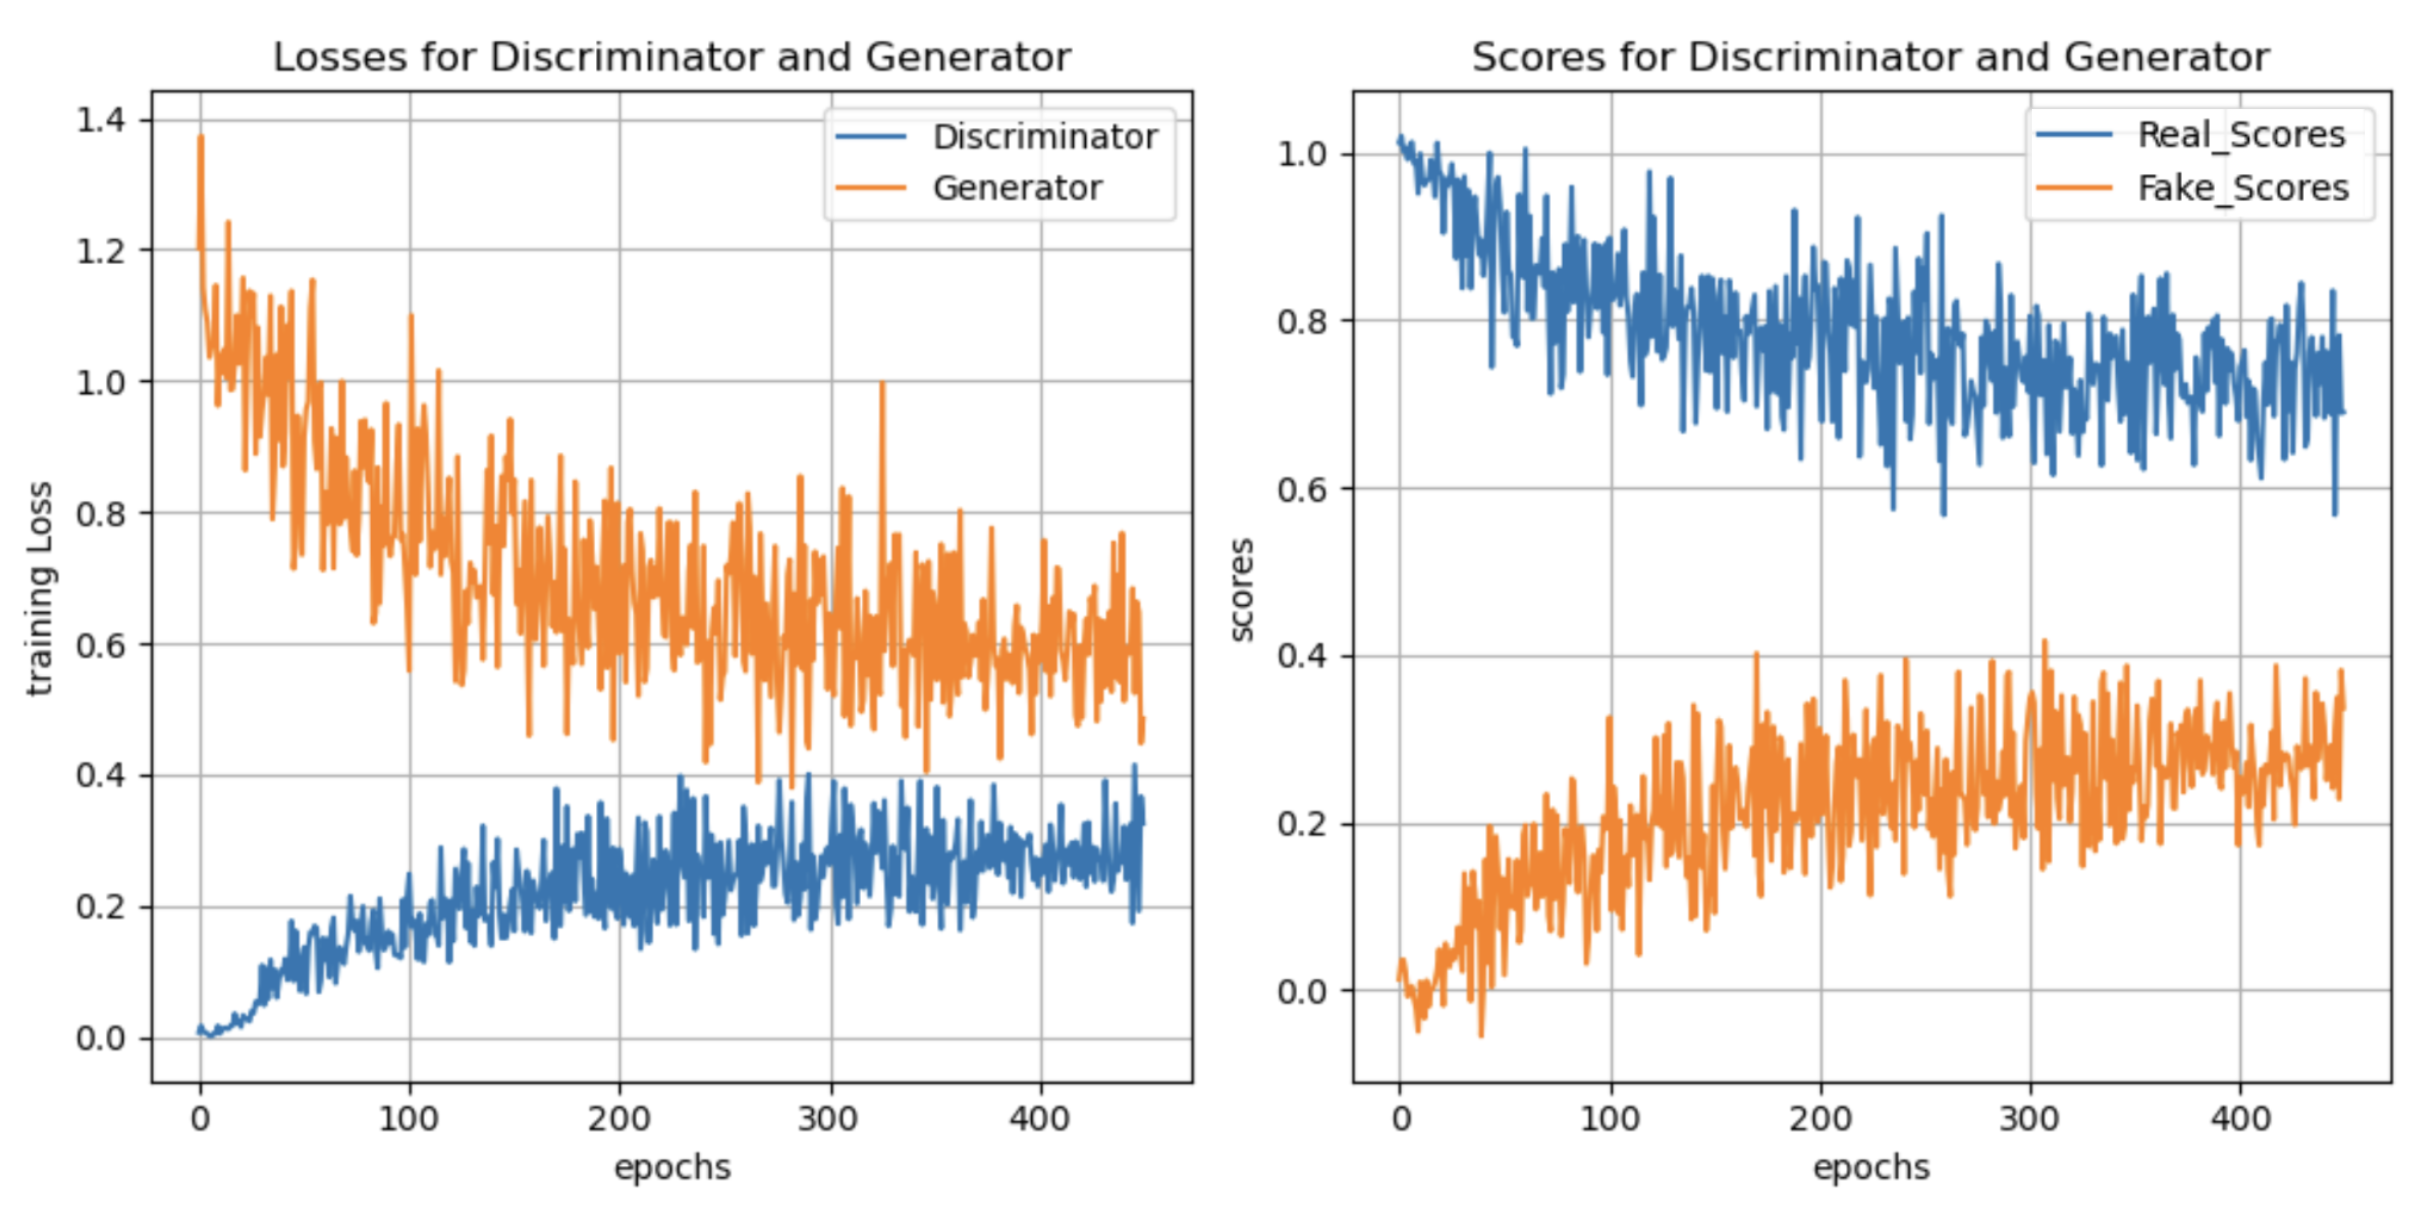

In [122]:
# Plots the training metrics for LSGAN which used the base model structure, only loss function is different.
plot_side_by_side(d_losses_ls, g_losses_ls, real_scores_ls, fake_scores_ls)

Its clear that loss is very less fromn the starting itself, and it reaches to equilibrium, and dont show sign of overfitting. And same applies to the scores plot.

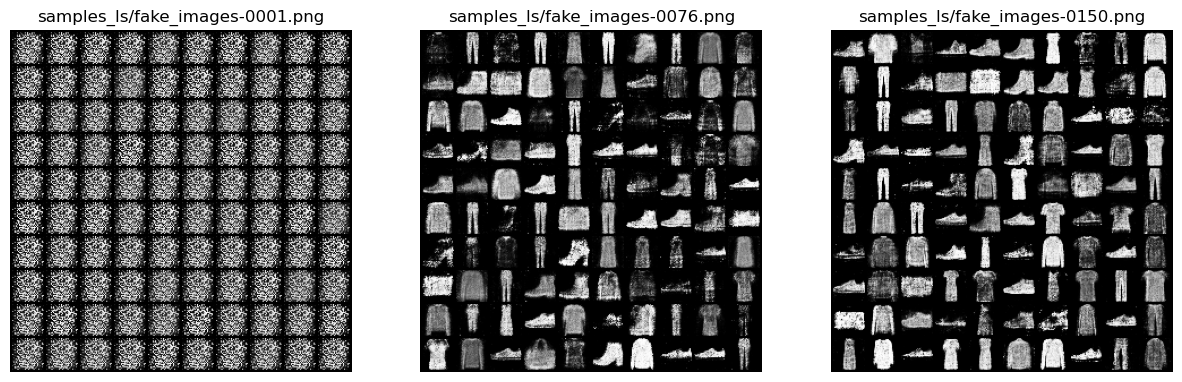

In [ ]:
# Showing sample images from the training process.
show_images(select_training_samples(sample_dir))

### Showing 3 images from 3 differnet states of model, from left to right as the training increases, GAN is getting more capable to show real life pictures.

In [ ]:
def discriminator_network_new_ls():
    """
    New Discriminator netowrk which will be training using MSE Loss function,
    so removed sigmoid activation function from output layer.
    Rest of the network is save as the improved network defined for the better performance.
    """
    return nn.Sequential(
        nn.Linear(image_size, hidden_size*2),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size*2, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, hidden_size),
        nn.LeakyReLU(0.2),
        nn.Linear(hidden_size, 1),
        )

D_ls_new = discriminator_network_new_ls()
D_ls_new.to(device);

G_ls_new = generator_network_new()
G_ls_new.to(device);


sample_dir = "sample_ls_new"

num_epochs      = 150
criterion_new   = nn.MSELoss()
d_optimizer_new = torch.optim.Adam(D_ls_new.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer_new = torch.optim.Adam(G_ls_new.parameters(), lr=0.0002, betas=(0.5, 0.999))

d_losses_ls_new, g_losses_ls_new, real_scores_ls_new, fake_scores_ls_new = train_gan(G_ls_new,
                                                                                     D_ls_new,
                                                                                     train_loader,
                                                                                     num_epochs,
                                                                                     sample_dir,
                                                                                     batch_size, latent_size,
                                                                                     criterion_new,
                                                                                     g_optimizer_new,
                                                                                     d_optimizer_new)

	Saving  sample_ls_new/fake_images-0000.png
Epoch [0/150], Step [200/600], d_loss: 0.0041, g_loss: 1.1557, D(x): 0.98, D(G(z)): -0.00
Epoch [0/150], Step [400/600], d_loss: 0.0145, g_loss: 1.2953, D(x): 1.00, D(G(z)): 0.02
Epoch [0/150], Step [600/600], d_loss: 0.1019, g_loss: 1.0695, D(x): 1.01, D(G(z)): 0.17
	Saving  sample_ls_new/fake_images-0001.png
Epoch [1/150], Step [200/600], d_loss: 0.0075, g_loss: 1.1049, D(x): 1.02, D(G(z)): 0.01
Epoch [1/150], Step [400/600], d_loss: 0.0084, g_loss: 1.0050, D(x): 0.97, D(G(z)): 0.01
Epoch [1/150], Step [600/600], d_loss: 0.0109, g_loss: 1.0742, D(x): 0.99, D(G(z)): 0.05
	Saving  sample_ls_new/fake_images-0002.png
Epoch [2/150], Step [200/600], d_loss: 0.0185, g_loss: 1.2771, D(x): 0.99, D(G(z)): 0.01
Epoch [2/150], Step [400/600], d_loss: 0.0233, g_loss: 1.0117, D(x): 0.95, D(G(z)): 0.01
Epoch [2/150], Step [600/600], d_loss: 0.0134, g_loss: 1.3412, D(x): 0.97, D(G(z)): -0.03
	Saving  sample_ls_new/fake_images-0003.png
Epoch [3/150], Step [

Epoch [26/150], Step [400/600], d_loss: 0.1459, g_loss: 0.8876, D(x): 0.86, D(G(z)): 0.14
Epoch [26/150], Step [600/600], d_loss: 0.1049, g_loss: 0.8242, D(x): 0.87, D(G(z)): 0.17
	Saving  sample_ls_new/fake_images-0027.png
Epoch [27/150], Step [200/600], d_loss: 0.1558, g_loss: 0.6432, D(x): 0.83, D(G(z)): 0.14
Epoch [27/150], Step [400/600], d_loss: 0.1413, g_loss: 0.8317, D(x): 0.87, D(G(z)): 0.17
Epoch [27/150], Step [600/600], d_loss: 0.0962, g_loss: 0.8619, D(x): 0.86, D(G(z)): 0.00
	Saving  sample_ls_new/fake_images-0028.png
Epoch [28/150], Step [200/600], d_loss: 0.1680, g_loss: 0.6851, D(x): 0.81, D(G(z)): 0.09
Epoch [28/150], Step [400/600], d_loss: 0.1423, g_loss: 0.8737, D(x): 0.84, D(G(z)): 0.16
Epoch [28/150], Step [600/600], d_loss: 0.1451, g_loss: 0.8893, D(x): 0.85, D(G(z)): 0.16
	Saving  sample_ls_new/fake_images-0029.png
Epoch [29/150], Step [200/600], d_loss: 0.1407, g_loss: 0.7804, D(x): 0.81, D(G(z)): 0.16
Epoch [29/150], Step [400/600], d_loss: 0.1689, g_loss: 0.

Epoch [52/150], Step [600/600], d_loss: 0.2898, g_loss: 0.6632, D(x): 0.64, D(G(z)): 0.19
	Saving  sample_ls_new/fake_images-0053.png
Epoch [53/150], Step [200/600], d_loss: 0.2639, g_loss: 0.7261, D(x): 0.70, D(G(z)): 0.24
Epoch [53/150], Step [400/600], d_loss: 0.2434, g_loss: 0.8049, D(x): 0.78, D(G(z)): 0.26
Epoch [53/150], Step [600/600], d_loss: 0.1998, g_loss: 0.8320, D(x): 0.79, D(G(z)): 0.21
	Saving  sample_ls_new/fake_images-0054.png
Epoch [54/150], Step [200/600], d_loss: 0.3409, g_loss: 0.5318, D(x): 0.63, D(G(z)): 0.24
Epoch [54/150], Step [400/600], d_loss: 0.2395, g_loss: 0.5710, D(x): 0.87, D(G(z)): 0.33
Epoch [54/150], Step [600/600], d_loss: 0.3179, g_loss: 0.4850, D(x): 0.65, D(G(z)): 0.29
	Saving  sample_ls_new/fake_images-0055.png
Epoch [55/150], Step [200/600], d_loss: 0.3299, g_loss: 0.5724, D(x): 0.75, D(G(z)): 0.38
Epoch [55/150], Step [400/600], d_loss: 0.2381, g_loss: 0.7880, D(x): 0.77, D(G(z)): 0.27
Epoch [55/150], Step [600/600], d_loss: 0.2240, g_loss: 0.

Epoch [79/150], Step [200/600], d_loss: 0.3337, g_loss: 0.5331, D(x): 0.70, D(G(z)): 0.37
Epoch [79/150], Step [400/600], d_loss: 0.3057, g_loss: 0.4334, D(x): 0.74, D(G(z)): 0.35
Epoch [79/150], Step [600/600], d_loss: 0.1765, g_loss: 0.7942, D(x): 0.81, D(G(z)): 0.17
	Saving  sample_ls_new/fake_images-0080.png
Epoch [80/150], Step [200/600], d_loss: 0.2303, g_loss: 0.7902, D(x): 0.77, D(G(z)): 0.19
Epoch [80/150], Step [400/600], d_loss: 0.2720, g_loss: 0.7136, D(x): 0.71, D(G(z)): 0.23
Epoch [80/150], Step [600/600], d_loss: 0.2705, g_loss: 0.7283, D(x): 0.79, D(G(z)): 0.27
	Saving  sample_ls_new/fake_images-0081.png
Epoch [81/150], Step [200/600], d_loss: 0.2864, g_loss: 0.6685, D(x): 0.71, D(G(z)): 0.26
Epoch [81/150], Step [400/600], d_loss: 0.2005, g_loss: 0.6921, D(x): 0.84, D(G(z)): 0.22
Epoch [81/150], Step [600/600], d_loss: 0.1922, g_loss: 0.8611, D(x): 0.76, D(G(z)): 0.12
	Saving  sample_ls_new/fake_images-0082.png
Epoch [82/150], Step [200/600], d_loss: 0.3308, g_loss: 0.

Epoch [105/150], Step [400/600], d_loss: 0.2595, g_loss: 0.5896, D(x): 0.68, D(G(z)): 0.22
Epoch [105/150], Step [600/600], d_loss: 0.3287, g_loss: 0.4738, D(x): 0.70, D(G(z)): 0.35
	Saving  sample_ls_new/fake_images-0106.png
Epoch [106/150], Step [200/600], d_loss: 0.2214, g_loss: 0.6693, D(x): 0.76, D(G(z)): 0.22
Epoch [106/150], Step [400/600], d_loss: 0.2241, g_loss: 0.6966, D(x): 0.77, D(G(z)): 0.24
Epoch [106/150], Step [600/600], d_loss: 0.2328, g_loss: 0.7112, D(x): 0.74, D(G(z)): 0.18
	Saving  sample_ls_new/fake_images-0107.png
Epoch [107/150], Step [200/600], d_loss: 0.2507, g_loss: 0.6379, D(x): 0.78, D(G(z)): 0.30
Epoch [107/150], Step [400/600], d_loss: 0.2163, g_loss: 0.6548, D(x): 0.83, D(G(z)): 0.25
Epoch [107/150], Step [600/600], d_loss: 0.2357, g_loss: 0.6687, D(x): 0.73, D(G(z)): 0.22
	Saving  sample_ls_new/fake_images-0108.png
Epoch [108/150], Step [200/600], d_loss: 0.1326, g_loss: 0.8617, D(x): 0.82, D(G(z)): 0.16
Epoch [108/150], Step [400/600], d_loss: 0.2390, 

Epoch [131/150], Step [400/600], d_loss: 0.4297, g_loss: 0.5431, D(x): 0.63, D(G(z)): 0.32
Epoch [131/150], Step [600/600], d_loss: 0.3037, g_loss: 0.5329, D(x): 0.71, D(G(z)): 0.31
	Saving  sample_ls_new/fake_images-0132.png
Epoch [132/150], Step [200/600], d_loss: 0.3023, g_loss: 0.5563, D(x): 0.68, D(G(z)): 0.31
Epoch [132/150], Step [400/600], d_loss: 0.2826, g_loss: 0.4566, D(x): 0.74, D(G(z)): 0.34
Epoch [132/150], Step [600/600], d_loss: 0.2213, g_loss: 0.6790, D(x): 0.76, D(G(z)): 0.24
	Saving  sample_ls_new/fake_images-0133.png
Epoch [133/150], Step [200/600], d_loss: 0.3197, g_loss: 0.6259, D(x): 0.66, D(G(z)): 0.26
Epoch [133/150], Step [400/600], d_loss: 0.3593, g_loss: 0.5353, D(x): 0.72, D(G(z)): 0.37
Epoch [133/150], Step [600/600], d_loss: 0.2144, g_loss: 0.7394, D(x): 0.75, D(G(z)): 0.19
	Saving  sample_ls_new/fake_images-0134.png
Epoch [134/150], Step [200/600], d_loss: 0.2656, g_loss: 0.8035, D(x): 0.70, D(G(z)): 0.17
Epoch [134/150], Step [400/600], d_loss: 0.2448, 

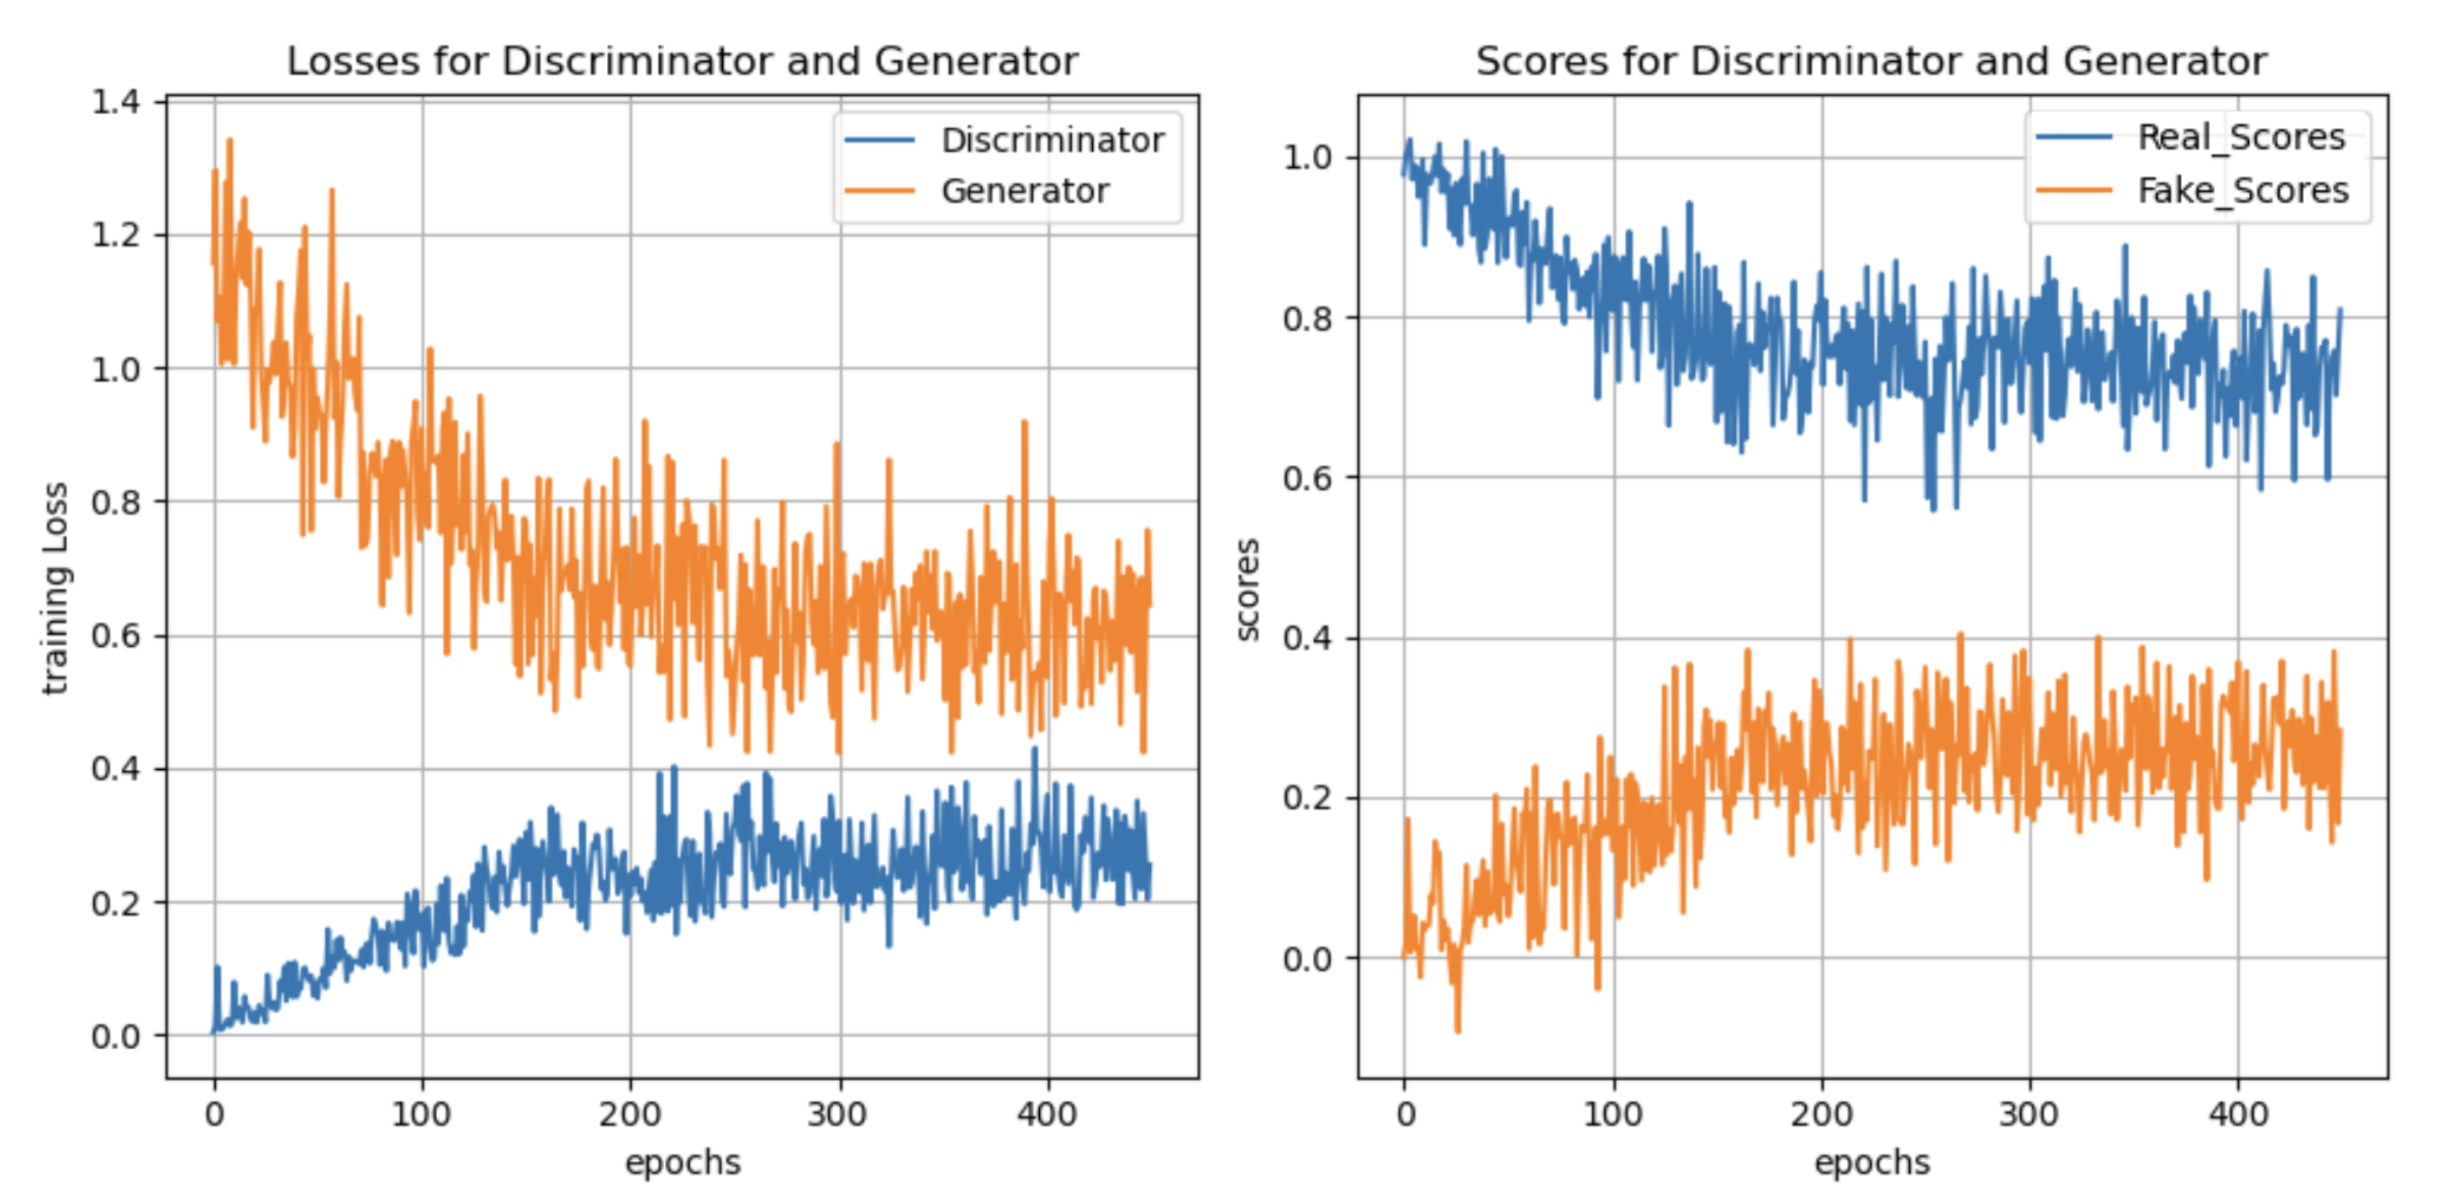

In [123]:
# Plots the training metrics for LSGAN which used the improved model structure, only loss function is different.
plot_side_by_side(d_losses_ls_new, g_losses_ls_new, real_scores_ls_new, fake_scores_ls_new)

Its clear that loss is very less fromn the starting itself, and it reaches to equilibrium, and dont show sign of overfitting. Here the scores plot also shows sign of equilibrium. After 200th epochs, there is not much change in the model's performance.

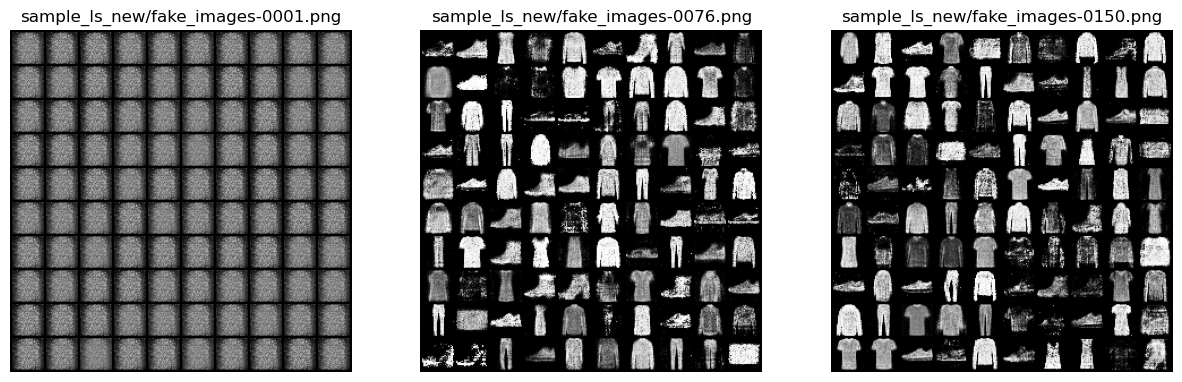

In [ ]:
# Showing sample images from the training process.
show_images(select_training_samples(sample_dir))

### Showing 3 images from 3 differnet states of model, from left to right as the training increases, GAN is getting more capable to show real life pictures.

<span ><h1 style="color:blue">Comparisions between GAN and LSGAN Performance </h1></span>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def smooth_data(data, window_size):
    """ This method returns the moving average for the given array and the window size"""
    smoothed_data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    return smoothed_data

def plot_comparision(d_losses, g_losses, real_scores, fake_scores, marker,
                     d_losses2, g_losses2, real_scores2, fake_scores2, marker2,
                     title, window_size=1):
    """
    This plots compare two differnet model and their discriminator and generator.
    It shows different plot for training loss and scores.
    """

    smoothed = "" if window_size == 1 else "(Smoothed)"

    plt.figure(figsize=(10,6))

    # Smooth the data
    d_losses_smoothed = smooth_data(d_losses, window_size=window_size)
    g_losses_smoothed = smooth_data(g_losses, window_size=window_size)
    real_scores_smoothed = smooth_data(real_scores, window_size=window_size)
    fake_scores_smoothed = smooth_data(fake_scores, window_size=window_size)
    d_losses2_smoothed = smooth_data(d_losses2, window_size=window_size)
    g_losses2_smoothed = smooth_data(g_losses2, window_size=window_size)
    real_scores2_smoothed = smooth_data(real_scores2, window_size=window_size)
    fake_scores2_smoothed = smooth_data(fake_scores2, window_size=window_size)

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(d_losses_smoothed, '--')
    plt.plot(g_losses_smoothed, '--')
    plt.plot(d_losses2_smoothed, '-')
    plt.plot(g_losses2_smoothed, '-')

    plt.xlabel("epochs")
    plt.ylabel("training Loss")
    plt.legend([f'{marker} Discriminator', f'{marker} Generator',
                f'{marker2} Discriminator', f'{marker2} Generator'])
    plt.grid(True)
    plt.title(f"Losses for Discriminator and Generator {smoothed}")

    # Plot scores
    plt.subplot(1, 2, 2)
    plt.plot(real_scores_smoothed, '--')
    plt.plot(fake_scores_smoothed, '--')
    plt.plot(real_scores2_smoothed, '-')
    plt.plot(fake_scores2_smoothed, '-')

    plt.xlabel("epochs")
    plt.ylabel("scores")
    plt.legend([f'{marker} Real Scpres ', f'{marker} Fake Scores',
                f'{marker2} Real Scores', f'{marker2} Fake Scores'])
    plt.grid(True)
    plt.title(f"Scores for Discriminator and Generator {smoothed}")

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

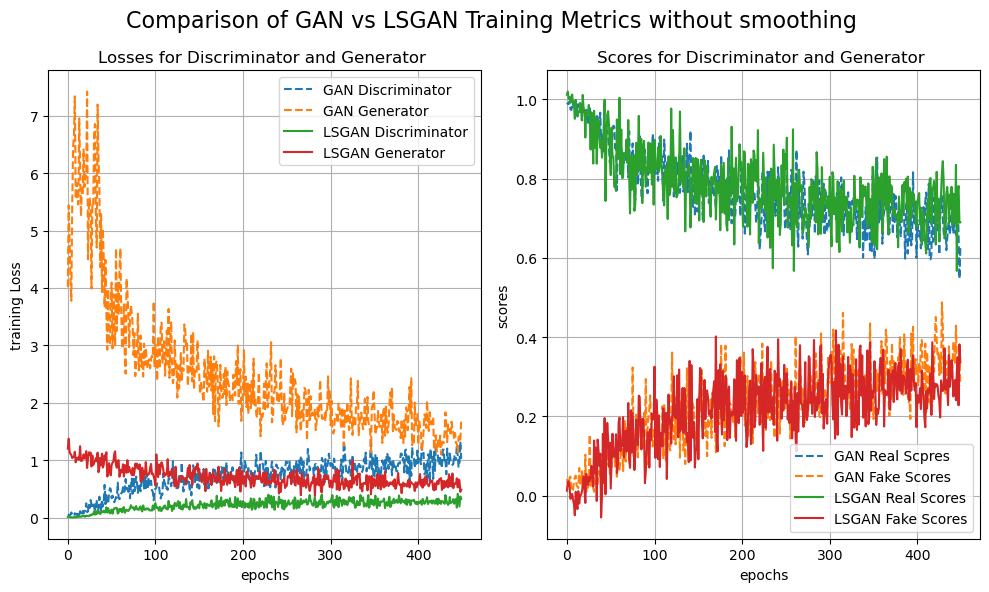

In [ ]:
plot_comparision(d_losses, g_losses, real_scores, fake_scores, "GAN",
                 d_losses_ls, g_losses_ls, real_scores_ls, fake_scores_ls, "LSGAN",
                 "Comparison of GAN vs LSGAN Training Metrics without smoothing ")

<span ><h2 style="color:RED">NOTE: As its clear from the above plot, with so much variance, its very difficul to see it clearly. Used moving average to smooth the plot, so we can see them clearly. For the moving average used the window_size of 9.</h2></span>
    

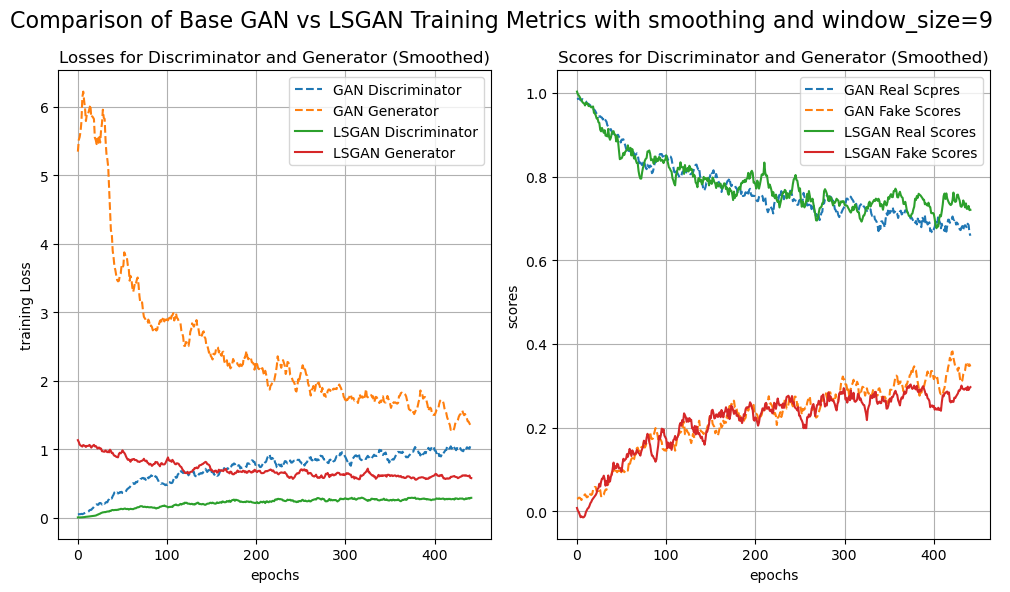

In [ ]:
plot_comparision(d_losses, g_losses, real_scores, fake_scores, "GAN",
                 d_losses_ls, g_losses_ls, real_scores_ls, fake_scores_ls, "LSGAN",
                 "Comparison of Base GAN vs LS-GAN Training Metrics with smoothing and window_size=9 ",
                 window_size=9)



### Base Model Comparision
* As we can see that LSGAN have less loss to begin with and it reached to equilibrium very fast compare to Normal GAN model.
* There is not much difference in the scores chart produced by both of the model.
* LSGAN reaches the equilibrium and maintains that, not showing any signs of the overfitting.


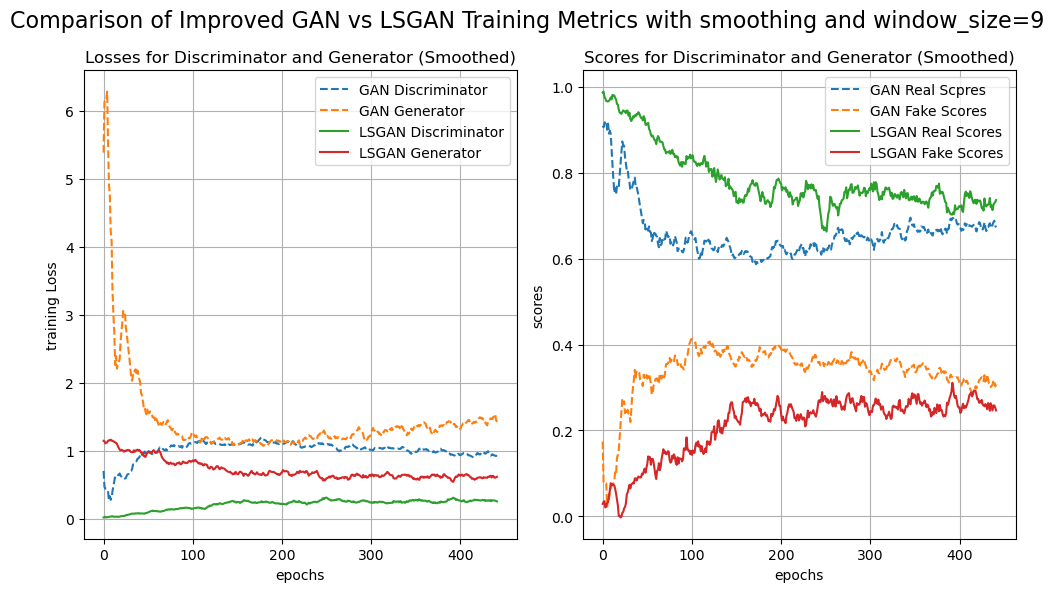

In [ ]:
plot_comparision(d_losses_new, g_losses_new, real_scores_new, fake_scores_new, "GAN",
                 d_losses_ls_new, g_losses_ls_new, real_scores_ls_new, fake_scores_ls_new, "LSGAN",
                 "Comparison of Improved GAN vs LSGAN Training Metrics with smoothing and window_size=9",
                 window_size=9)

### Improved Model Comparision

* Here we can see that with improved GAN model starts with big loss but quickly reaches the equilibrium.
* Later it also show the divergence as the training goes after the 200 epoch, shows signs of overfitting.
* Same characterstics is visible in the scores model also, shows better results than LSGAN. It also start drifting after the 200 epochs.


* LSGAN shows resiliant performance, the loss plot doesn't show much of the improvement over base model, and its very identical to the Base LSGAN.
* For the scores plot, LSGAN also very similar to the Base LSGAN model. With Improved LSGAN model, we can see faster convergence compared to Base LSGAN model.

* For both model, if run the training for more iterations, we would have see better scores value, because it shows a trend of improvement. Here it shows the signs of convergence.



Overall, the Improved GAN, show good results quickly but started overfitting. But LSGAN base model also shows good results, and improved model made slight improvements for scores convergence over the base model.
